In [2]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import statsmodels.api as sm
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt


warnings.filterwarnings('ignore')
import seaborn as sns
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

In [3]:
# Correlation plots for all days, all fires
rave_all = pd.DataFrame()
pws_all = pd.DataFrame()
merra_lagged_all = pd.DataFrame()
merra_movingaverage_all = pd.DataFrame()

fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'DOLAN', 'HOLIDAY FARM','CREEK', 'LAKE', 'CAMERON PEAK', 'PINE GULCH']
for ii in range(len(fire_incidents)):
    rave = pd.read_csv(fire_incidents[ii]+'_Daily_RAVE.csv')
    inds_active = np.where(rave['Mean_FRP']>10)[0] #this is the threshold I used at NOAA
    
    rave=rave.iloc[inds_active]
    pws = pd.read_csv(fire_incidents[ii]+'_Daily_PWS.csv').iloc[inds_active]   
    merra_lagged = pd.read_csv(fire_incidents[ii]+'_Daily_MERRA_Lagged.csv').iloc[inds_active]
    merra_movingaverage = pd.read_csv(fire_incidents[ii]+'_Daily_MERRA_Moving_Average_2.csv').iloc[inds_active]
    plot_correlations(pws, merra_lagged, merra_movingaverage,rave, fire_incidents[ii])
    plot_twoline(merra_lagged['day'], np.stack([pws['pws'], rave['CO']]),fire_incidents[ii] ,\
             [], ['PWS', 'CO (kg)'], 1)
    plot_twoline(merra_lagged['day'], np.stack([merra_movingaverage['vpd'], rave['CO']]),fire_incidents[ii] ,\
             [], ['VPD (hpa)', 'CO (kg)'], 1)
    
    rave_all = pd.concat([rave_all,rave], axis=0)
    pws_all = pd.concat([pws_all,pws], axis=0)
    merra_lagged_all = pd.concat([merra_lagged_all,merra_lagged], axis=0)
    merra_movingaverage_all = pd.concat([merra_movingaverage_all,merra_movingaverage], axis=0)

FileNotFoundError: [Errno 2] No such file or directory: 'AUGUST COMPLEX_Daily_PWS.csv'

[ 58  59  60  61  62  63  64  65  66  68  69  70  71  72  73  77  78  79
 166 168 169 170 172]
[  1   2  53  54  55  67  74  75  76  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 118 119 122
 123 124 125 126 127 128 130 131 132 133 134 135 136 137 138 141 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 167 171 173 184 188 189 203 204 210]
[  0   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  56  57  80
  81  82  83  84  85  86 111 112 113 114 115 116 117 120 121 129 139 140
 142 143 174 175 176 177 178 179 180 181 182 183 185 186 187 190 191 192
 193 194 195 196 197 198 199 200 201 202 205 206 207 208 209]


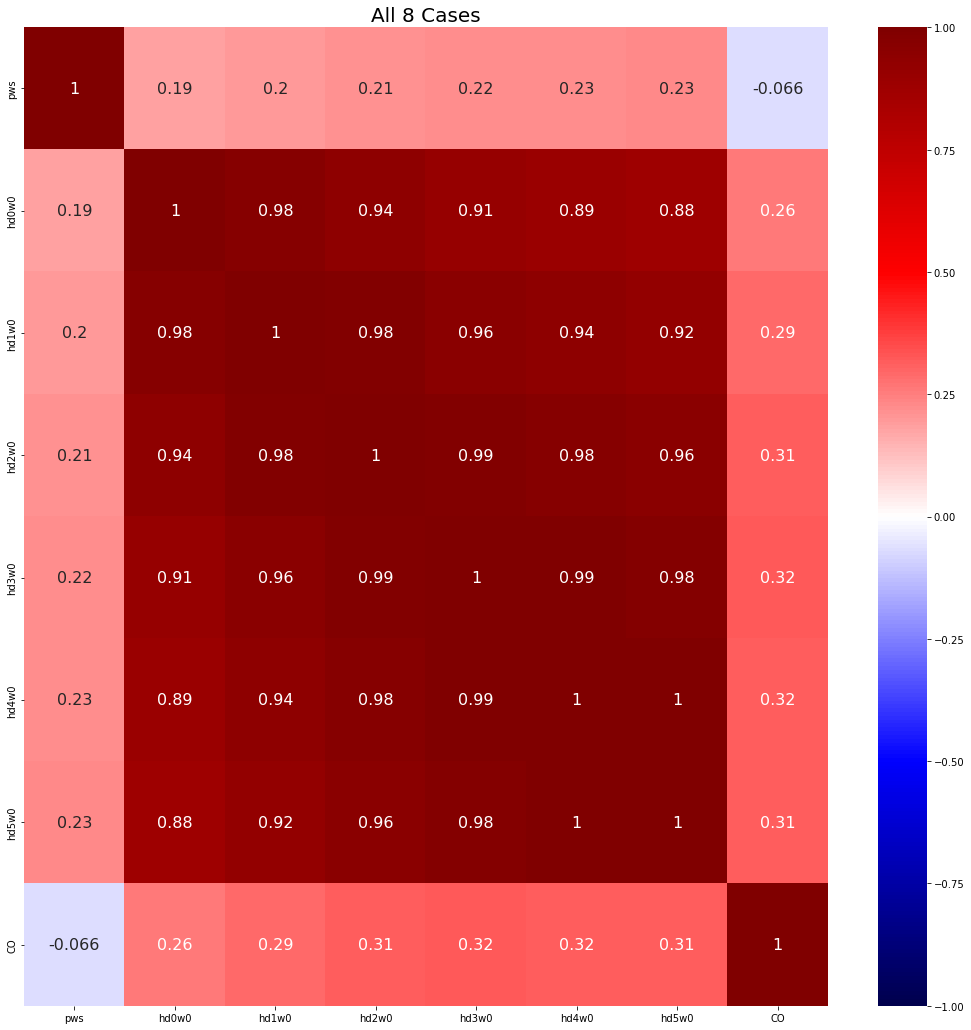

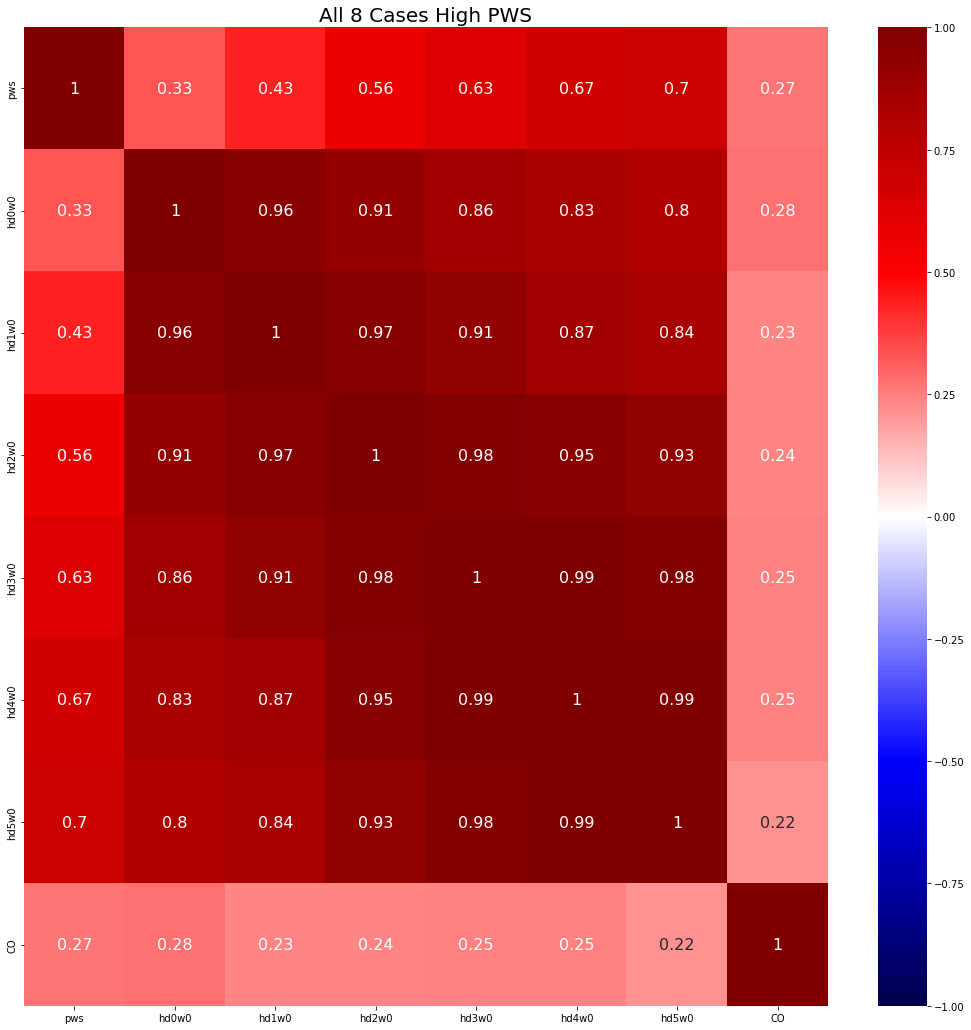

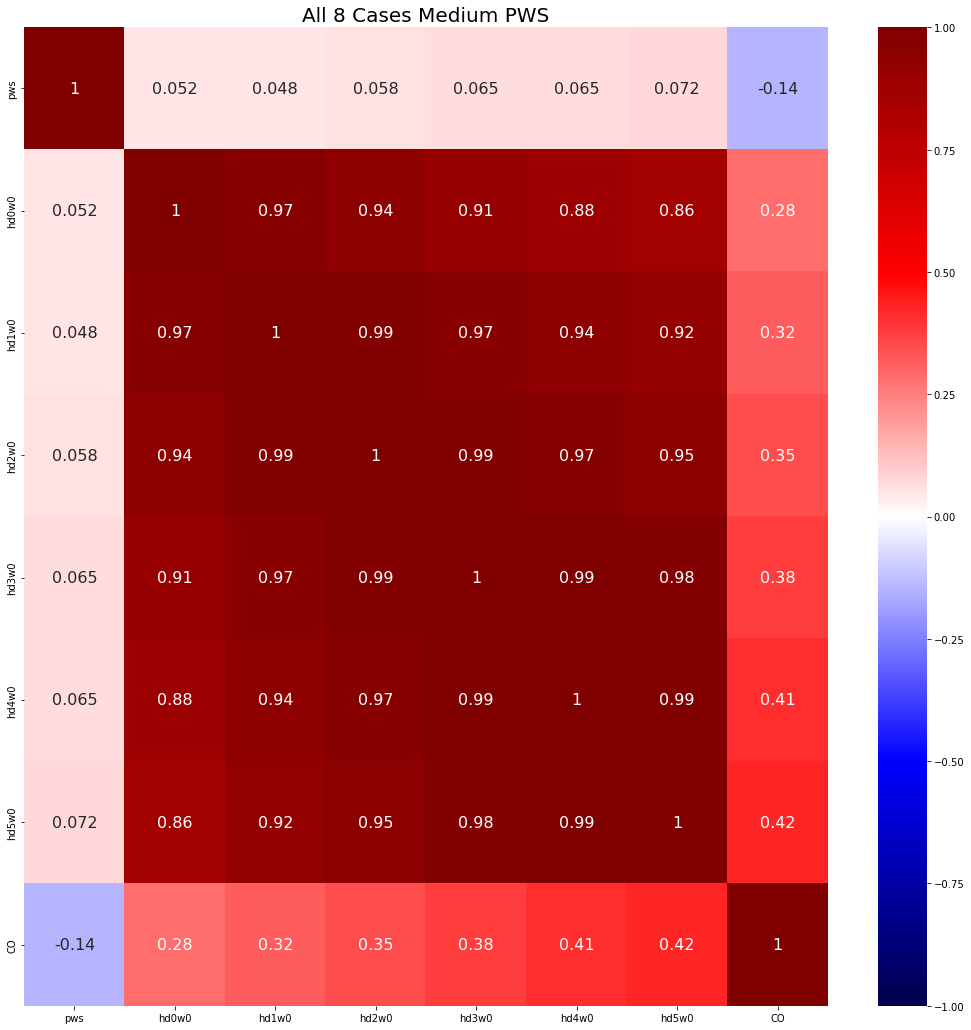

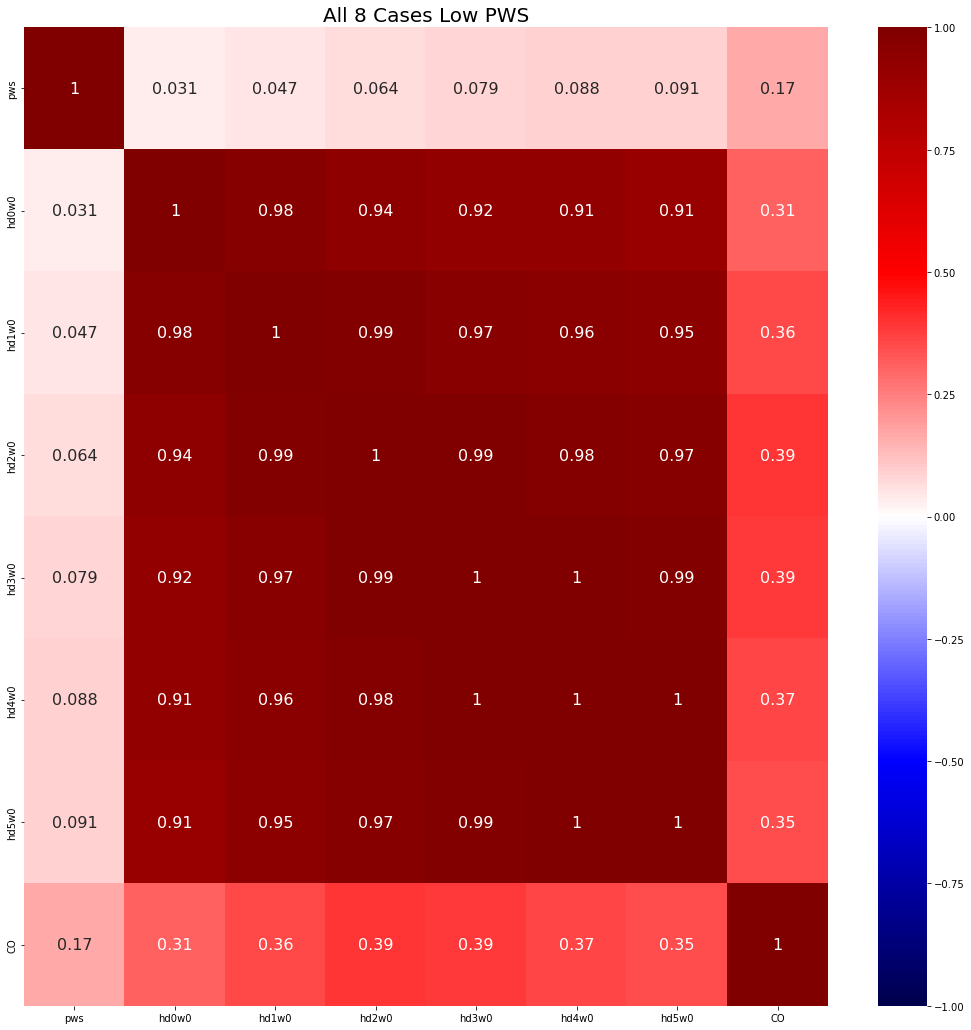

In [27]:
inds_high_pws = np.where(pws_all['pws']>1.5)[0]
inds_med_pws = np.where((pws_all['pws']<=1.5)&(pws_all['pws']>=1))[0]
inds_low_pws = np.where(pws_all['pws']<1)[0]

print(inds_high_pws)
print(inds_med_pws)
print(inds_low_pws)

plot_correlations(pws_all, merra_lagged_all, merra_movingaverage_all,rave_all, 'All 8 Cases')

plot_correlations(pws_all.iloc[inds_high_pws], merra_lagged_all.iloc[inds_high_pws],
                  merra_movingaverage_all.iloc[inds_high_pws],rave_all.iloc[inds_high_pws], 'All 8 Cases High PWS')

plot_correlations(pws_all.iloc[inds_med_pws], merra_lagged_all.iloc[inds_med_pws],
                  merra_movingaverage_all.iloc[inds_med_pws],rave_all.iloc[inds_med_pws], 'All 8 Cases Medium PWS')

plot_correlations(pws_all.iloc[inds_low_pws], merra_lagged_all.iloc[inds_low_pws],
                  merra_movingaverage_all.iloc[inds_low_pws],rave_all.iloc[inds_low_pws], 'All 8 Cases Low PWS')

In [26]:
def plot_correlations(df_pws, df_merra_lagged, df_merra_movingaverage,df_rave, fig_title):
    #concatenate all the dataframes
    df_all = pd.concat([df_pws.drop(columns=['Unnamed: 0']),\
                    #df_merra_lagged.drop(columns=['Unnamed: 0', 'frp', 'area', 'num points']),\
                    df_merra_movingaverage.drop(columns=['Unnamed: 0','temp','vpd','wind', 'frp','area', 'num points']),\
                    df_rave['CO']], axis=1)

    corrMatrix = df_all.corr()
    fig,ax=plt.subplots(figsize=(18,18))
    sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic', annot_kws={'fontsize':16})
    plt.title(fig_title, fontsize=20)
    plt.show()

## Load in the time series for August Complex

In [34]:
df_merra = pd.read_csv('AC_Daily_MERRA.csv').iloc[0:50]
df_rave = pd.read_csv('AC_Daily_RAVE.csv').iloc[0:50]
df_ncar = pd.read_csv('AC_Daily_NCAR_Moisture.csv').iloc[0:50]
df_personnel = pd.read_csv('AC_Daily_Personnel.csv').iloc[0:50]
df_pws = pd.read_csv('AC_Daily_PWS.csv').iloc[0:50]
df_movingaverage = pd.read_csv('AC_Daily_MERRA_movingaverage.csv').iloc[0:50]


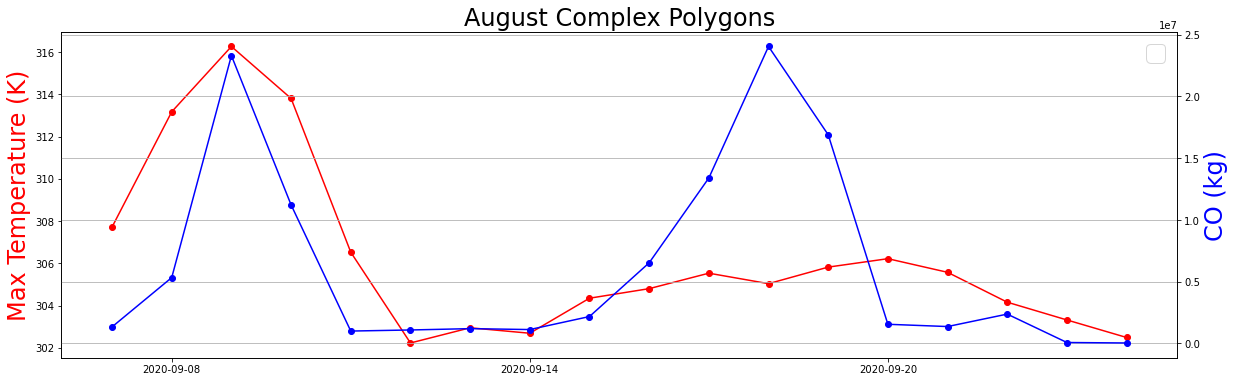

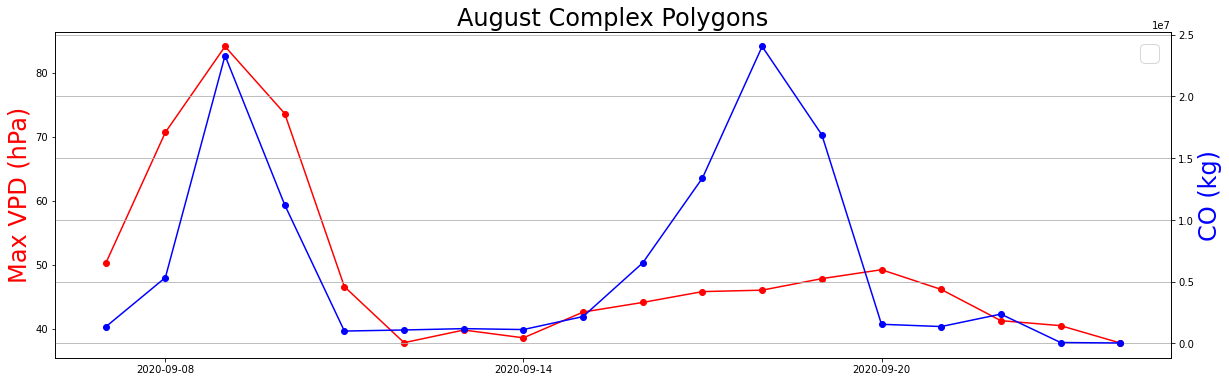

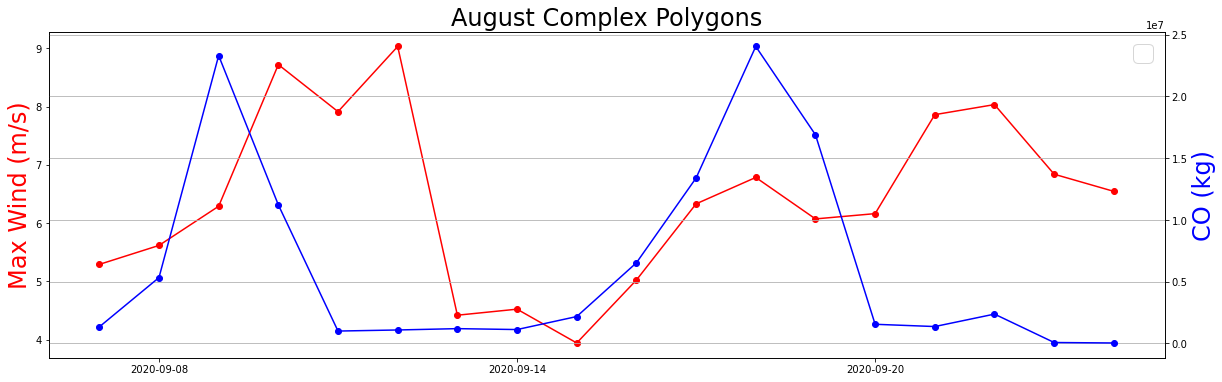

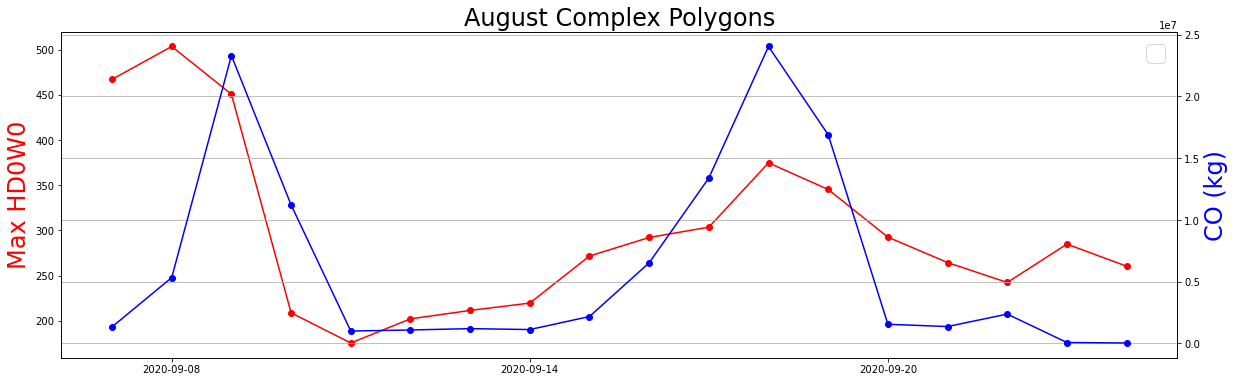

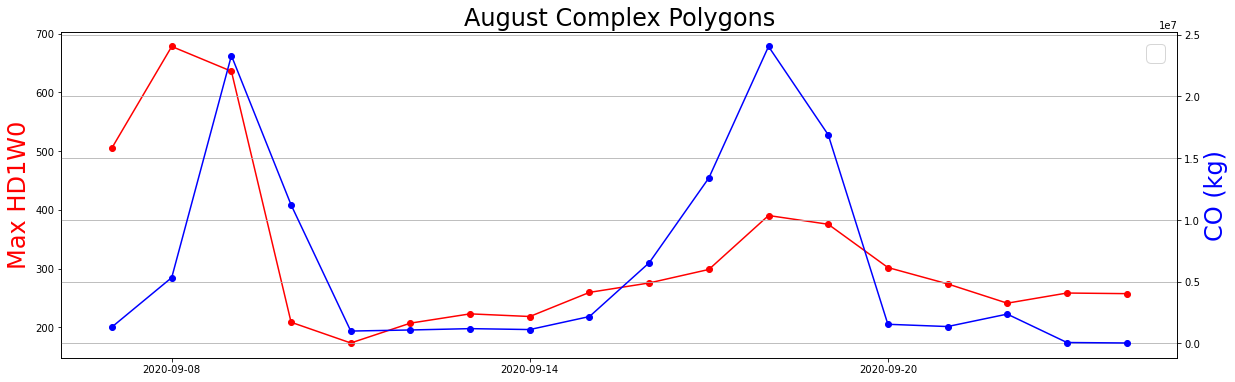

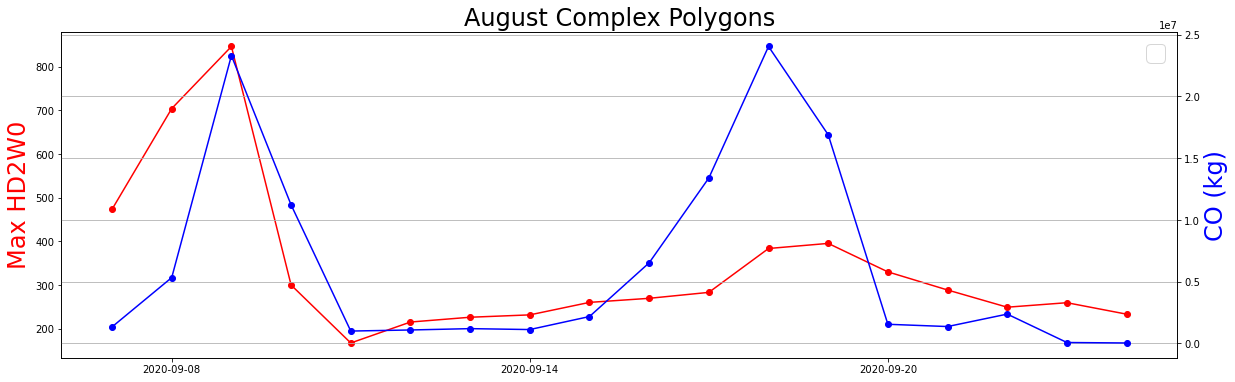

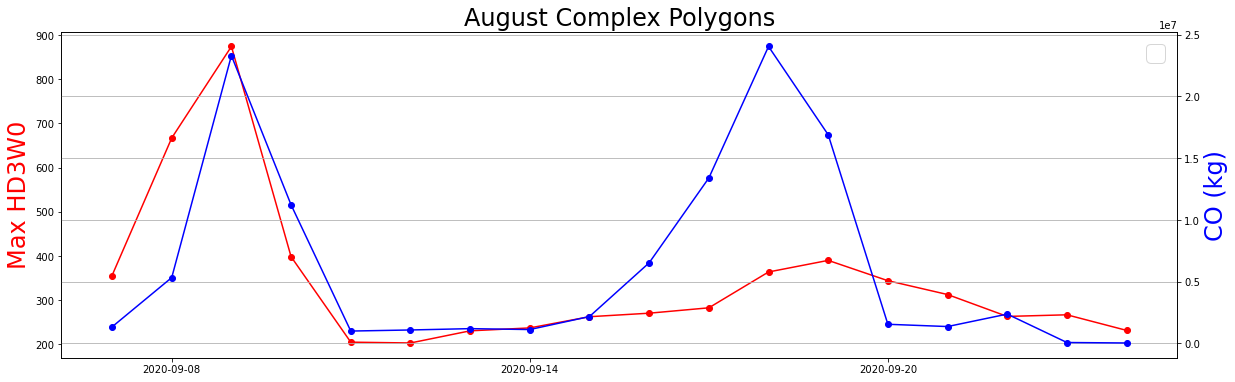

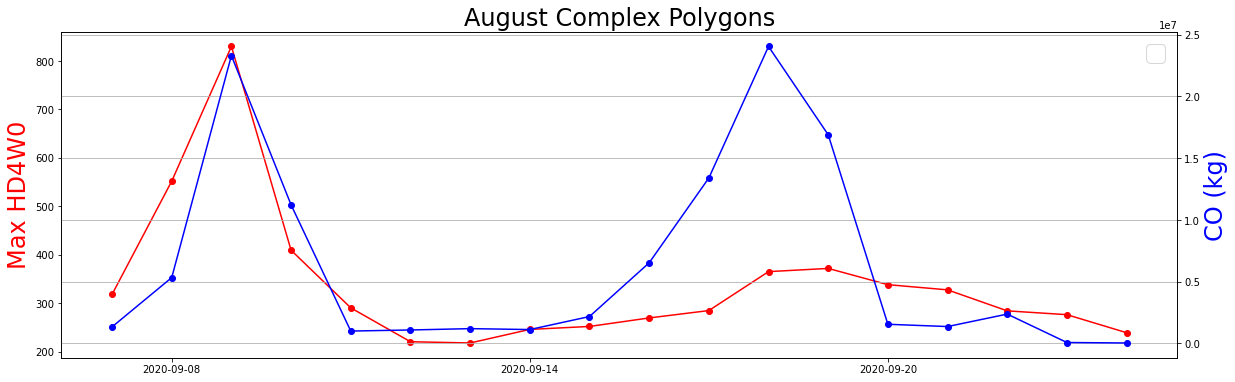

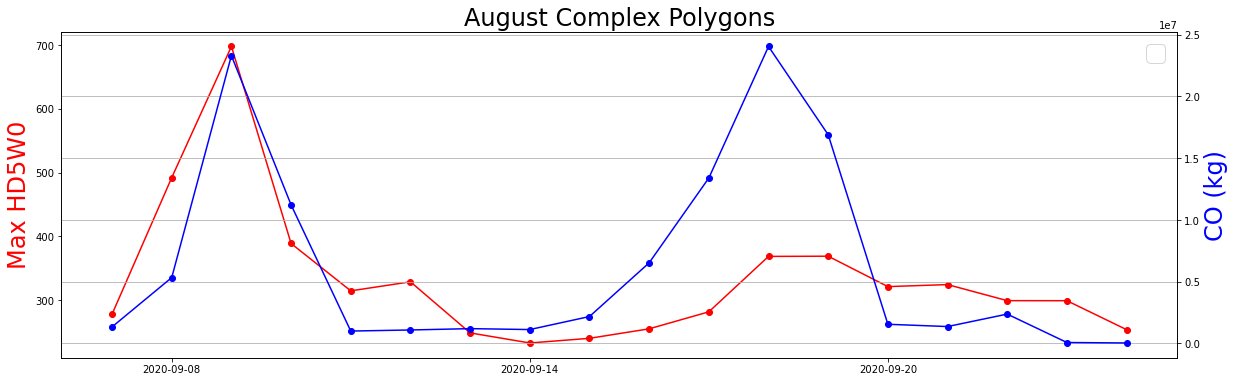

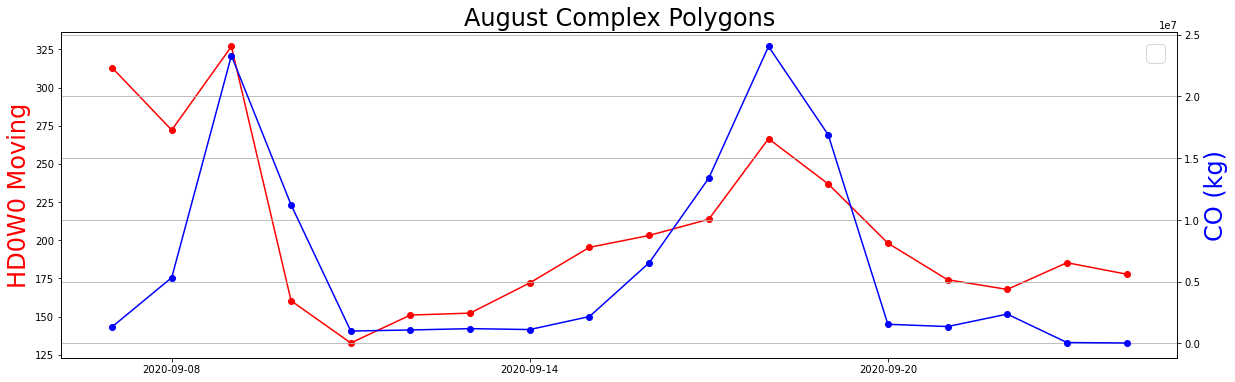

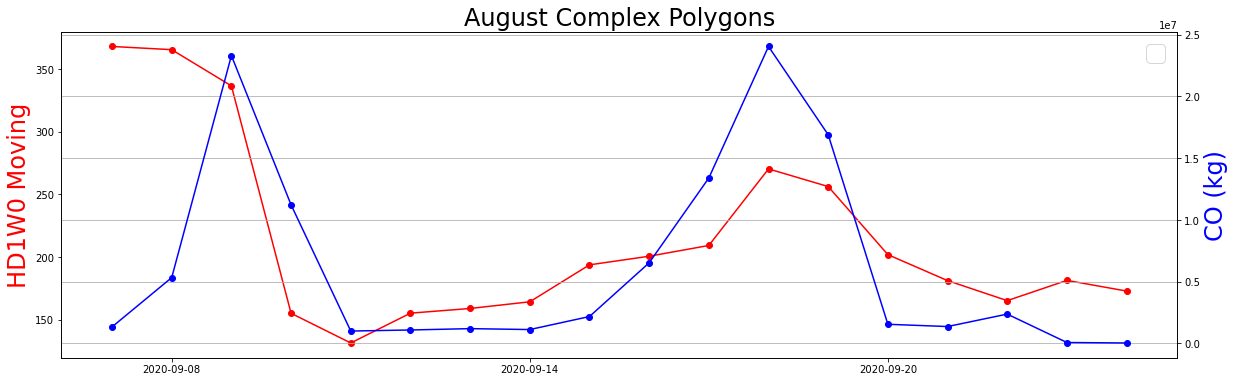

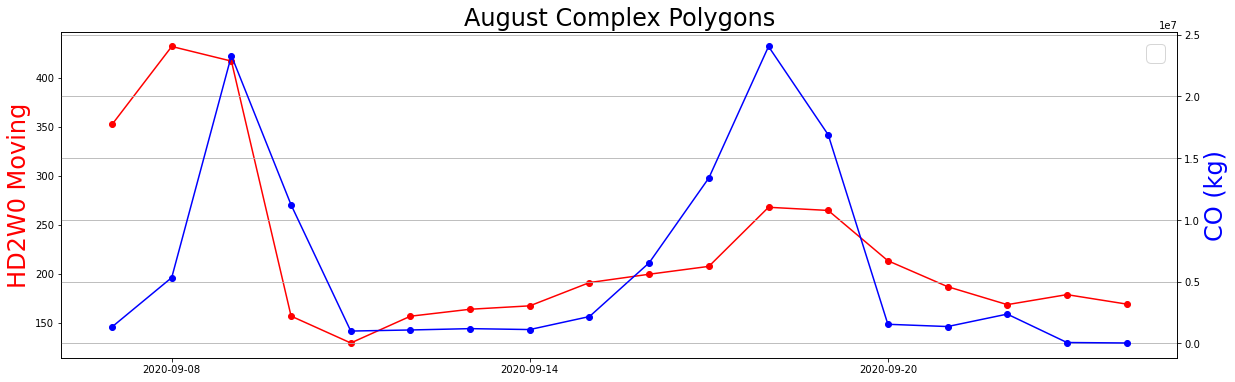

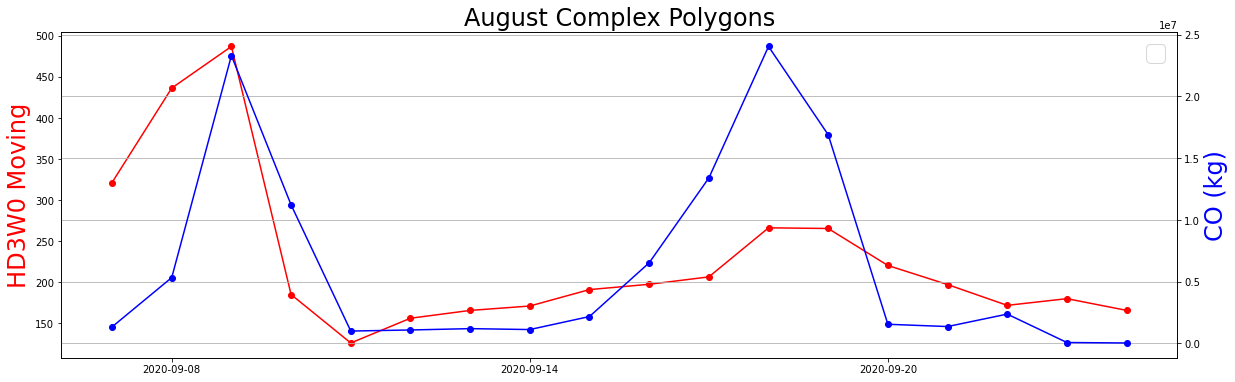

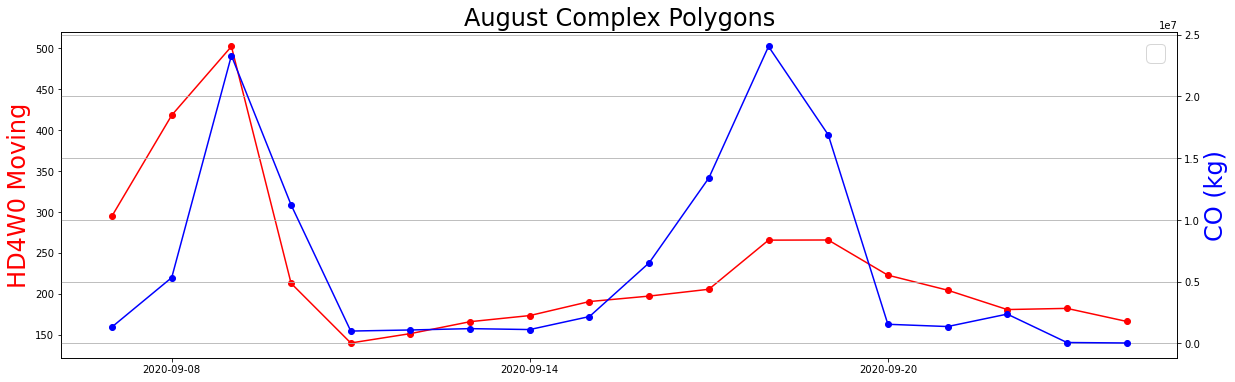

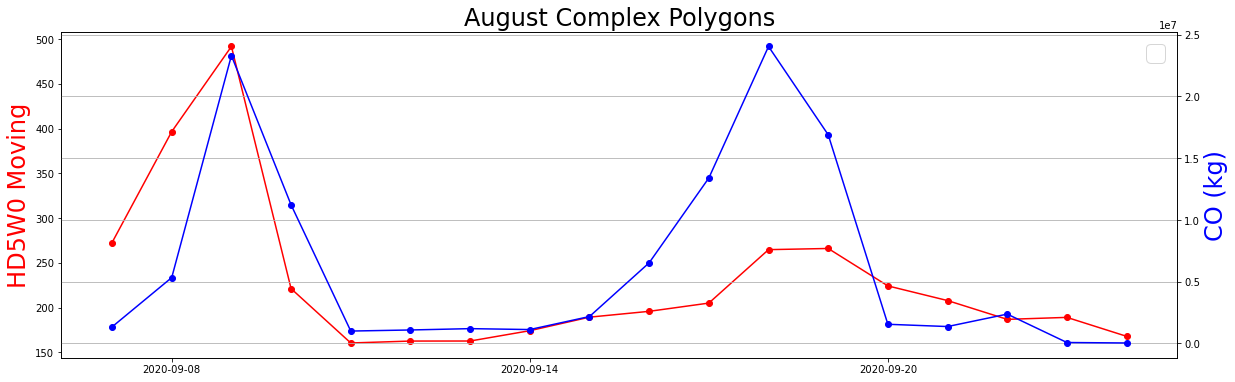

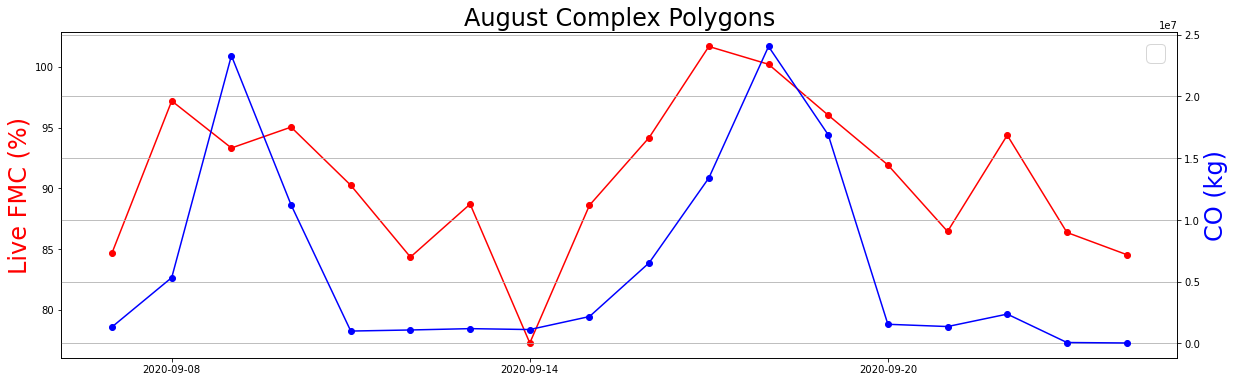

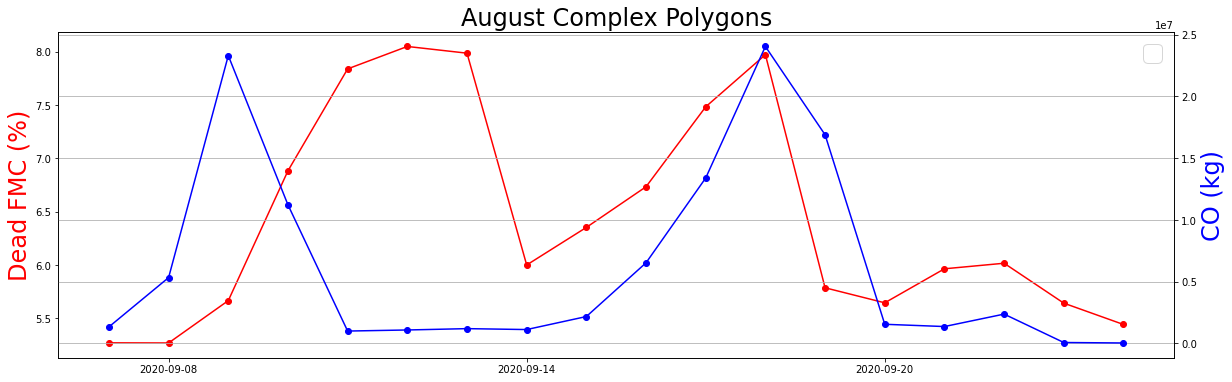

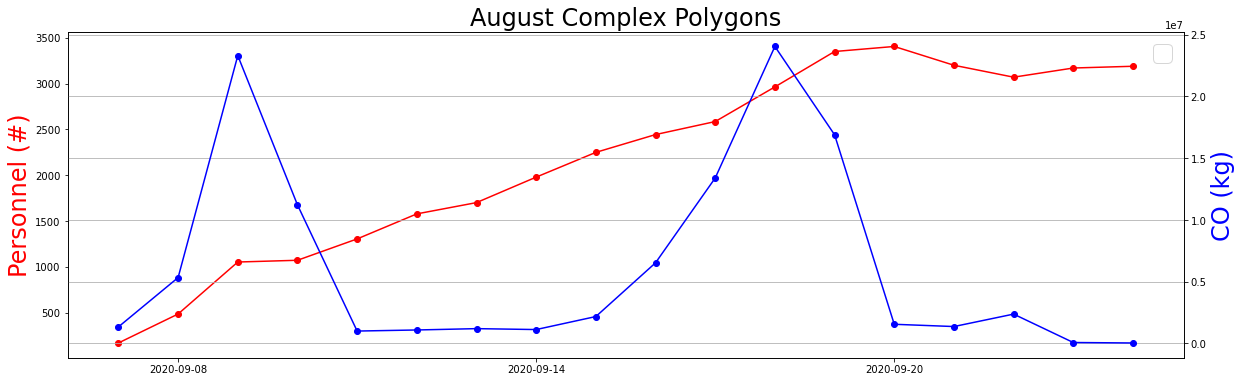

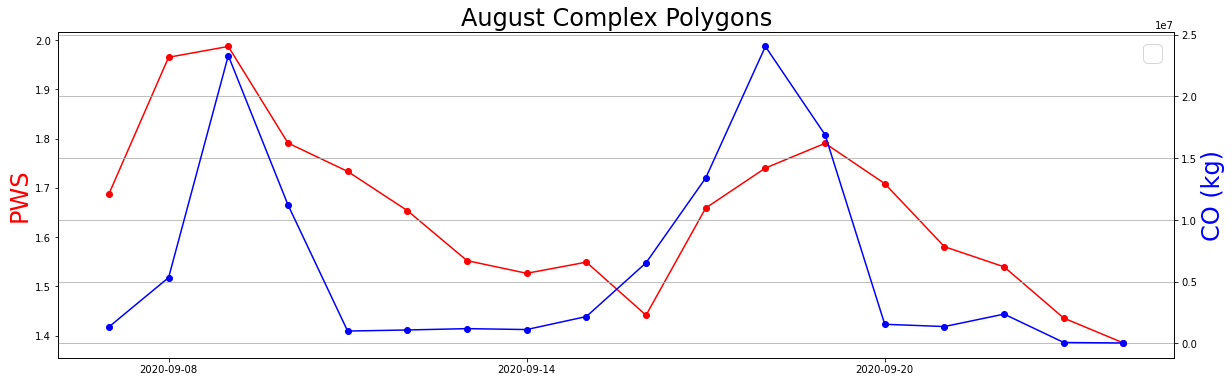

In [30]:
plot_twoline(df_merra['day'], np.stack([df_merra['temp'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['Max Temperature (K)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['vpd'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['Max VPD (hPa)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['wind'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['Max Wind (m/s)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_merra['hd0w0'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['Max HD0W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd1w0'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['Max HD1W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd2w0'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['Max HD2W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd3w0'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['Max HD3W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd4w0'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['Max HD4W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd5w0'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['Max HD5W0', 'CO (kg)'], 1)

plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd0w0_MA'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['HD0W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd1w0_MA'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['HD1W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd2w0_MA'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['HD2W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd3w0_MA'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['HD3W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd4w0_MA'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['HD4W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd5w0_MA'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['HD5W0 Moving', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_ncar['mlive']*100, df_rave['CO']]), 'August Complex Polygons',\
             [], ['Live FMC (%)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_ncar['mdead']*100, df_rave['CO']]), 'August Complex Polygons',\
             [], ['Dead FMC (%)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_personnel['personnel'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['Personnel (#)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_pws['pws'], df_rave['CO']]), 'August Complex Polygons',\
             [], ['PWS', 'CO (kg)'], 1)

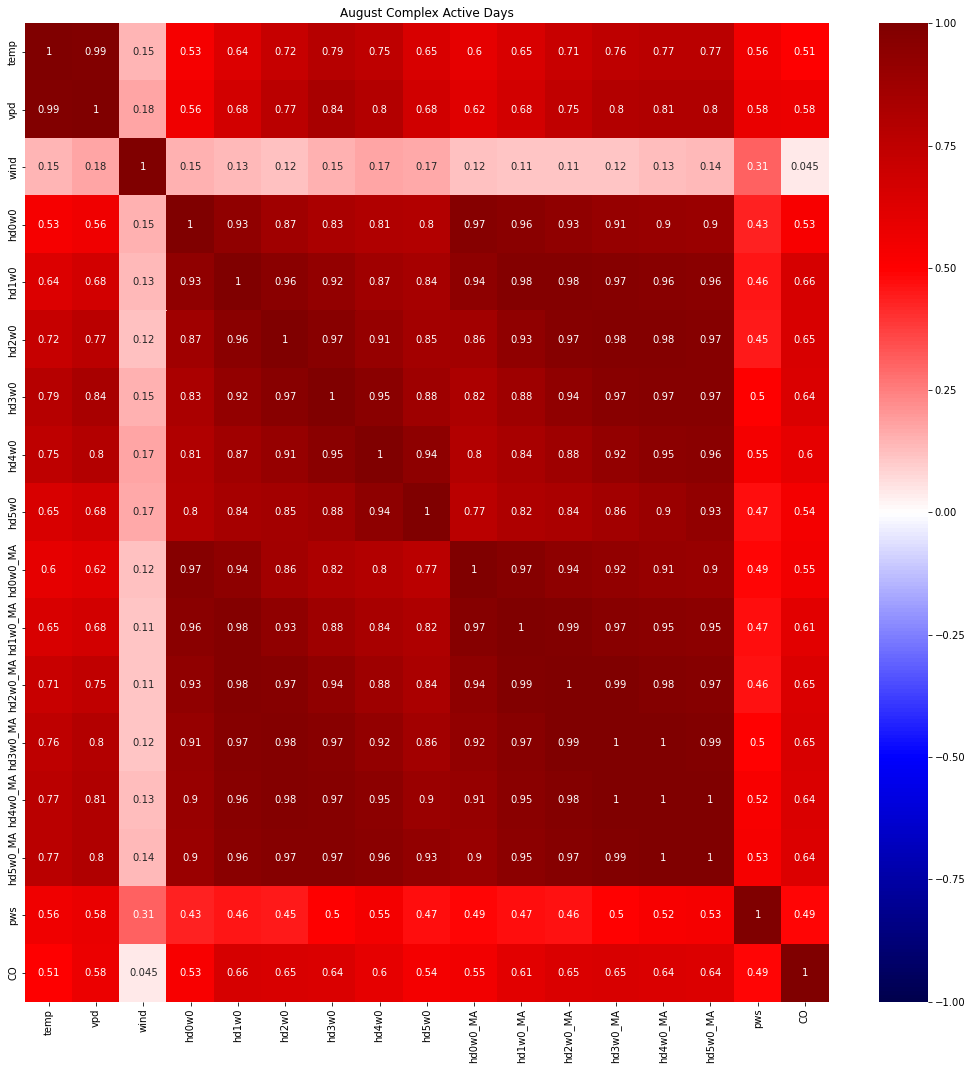

In [35]:
#concatenate all the dataframes
df_all = pd.concat([df_merra.drop(columns=['Unnamed: 0', 'frp', 'area', 'num points']),\
                    df_movingaverage.drop(columns=['Unnamed: 0','temp','vpd','wind', 'frp', 'area', 'num points']),\
                    #df_ncar.drop(columns=['Unnamed: 0']),\
                    #df_personnel.drop(columns=['Unnamed: 0']),\
                    df_pws.drop(columns=['Unnamed: 0']),\
                    df_rave['CO']], axis=1)
df_all
corrMatrix = df_all.corr()
fig,ax=plt.subplots(figsize=(18,18))
sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic')
plt.title('August Complex Active Days')
plt.show()

## Bobcat Fire

In [36]:
df_merra = pd.read_csv('BOBCAT_Daily_MERRA.csv').iloc[0:18]
df_rave = pd.read_csv('BOBCAT_Daily_RAVE.csv').iloc[0:18]
df_ncar = pd.read_csv('BOBCAT_Daily_NCAR_Moisture.csv').iloc[0:18]
df_personnel = pd.read_csv('BOBCAT_Daily_Personnel.csv').iloc[0:18]
df_pws = pd.read_csv('BOBCAT_Daily_PWS.csv').iloc[0:18]
df_movingaverage = pd.read_csv('BOBCAT_Daily_MERRA_movingaverage.csv').iloc[0:18]


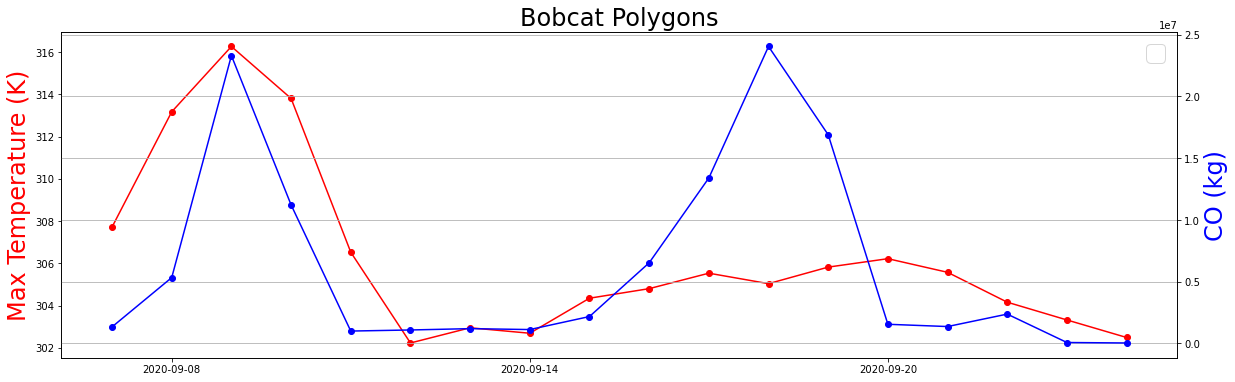

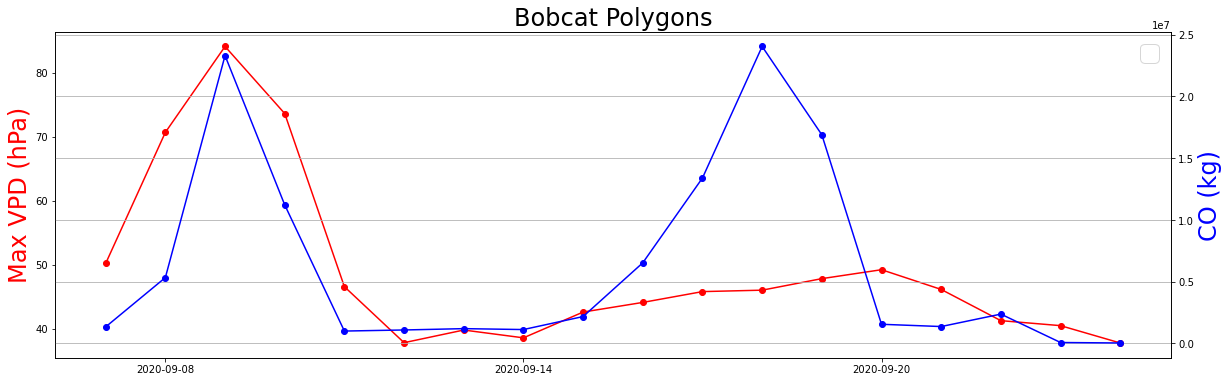

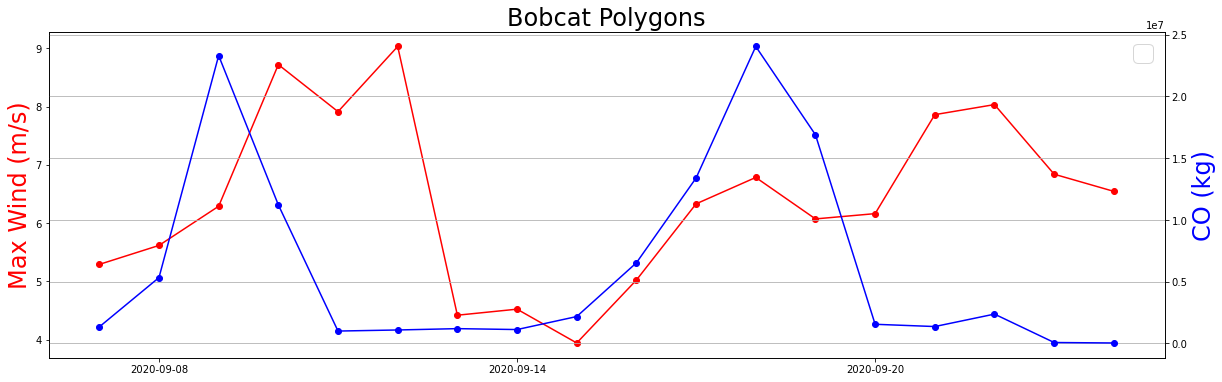

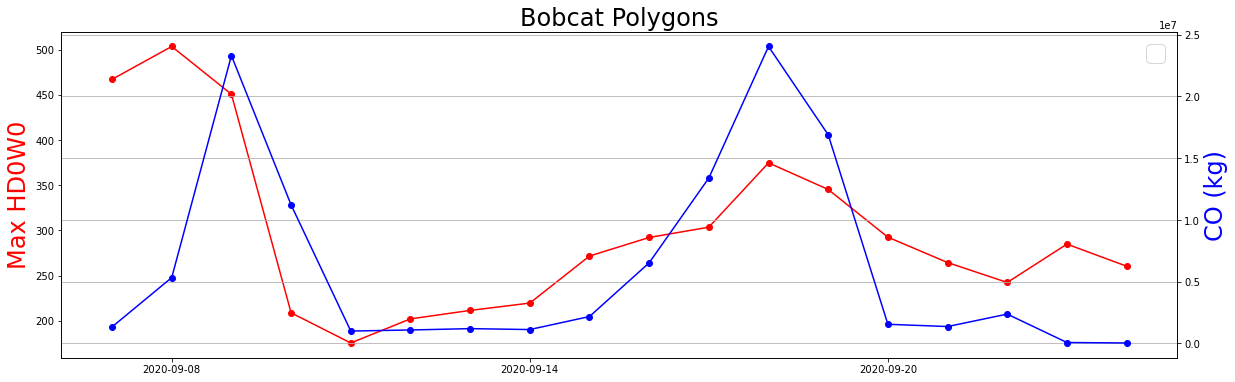

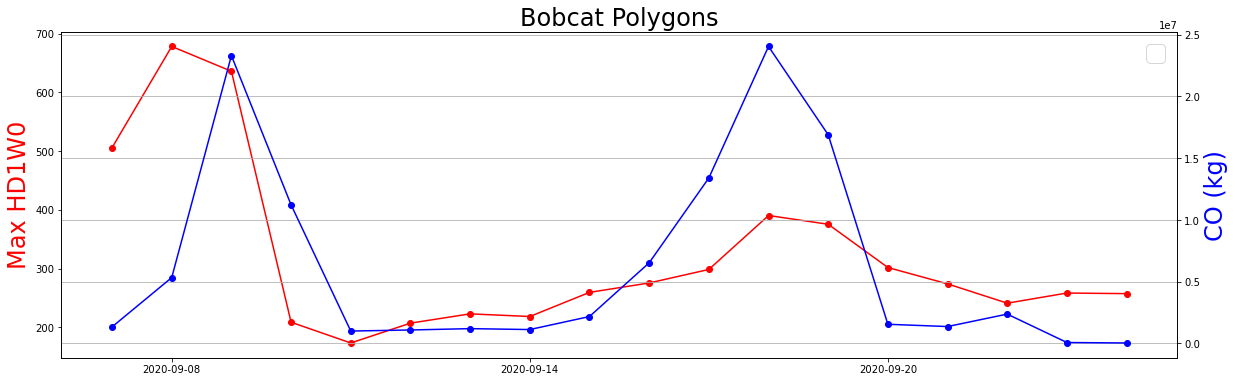

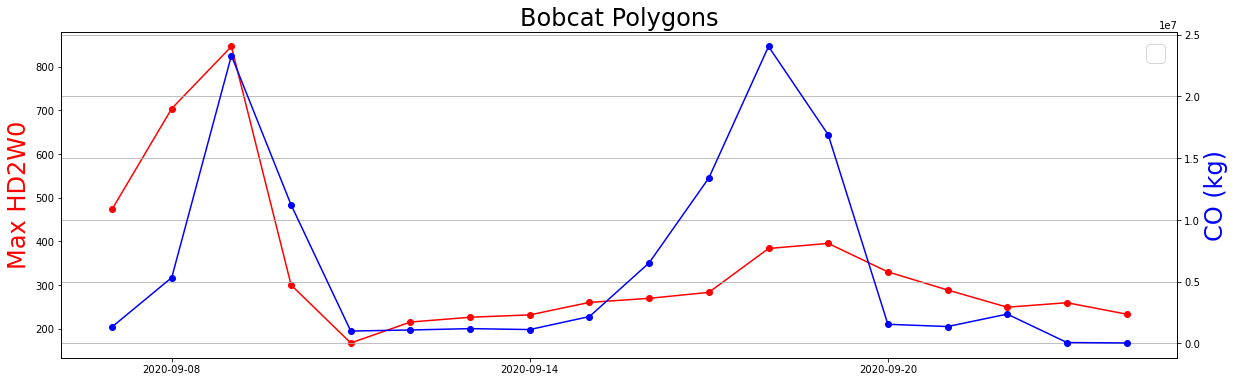

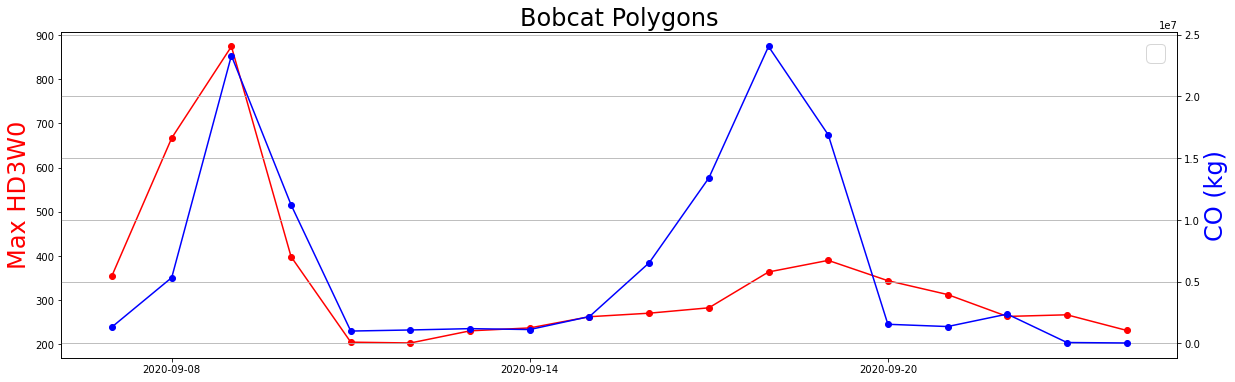

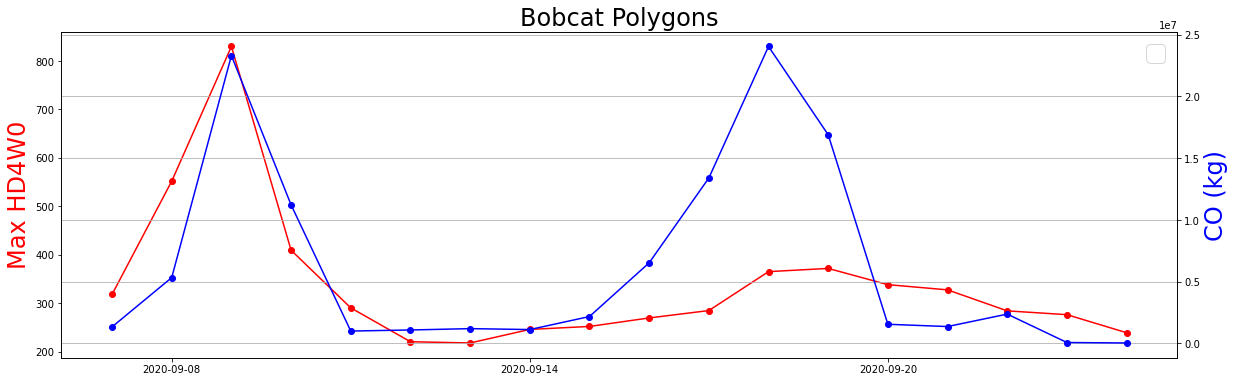

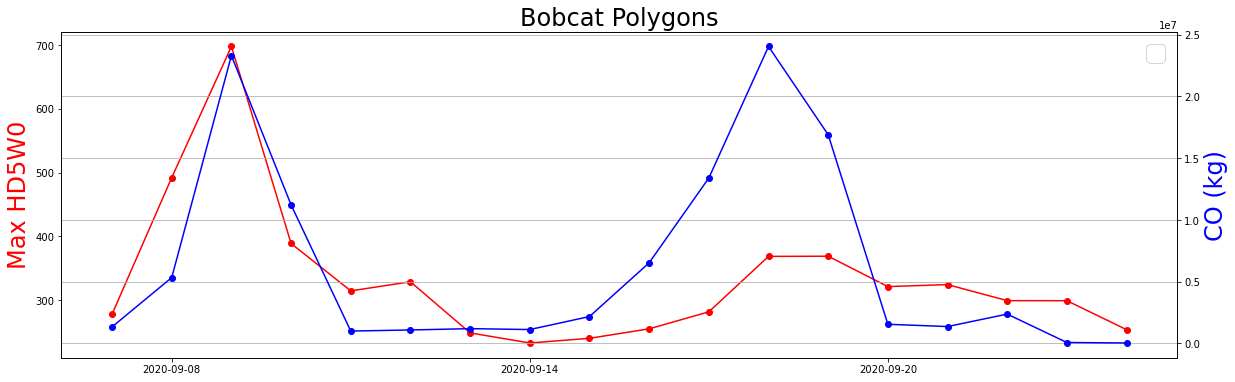

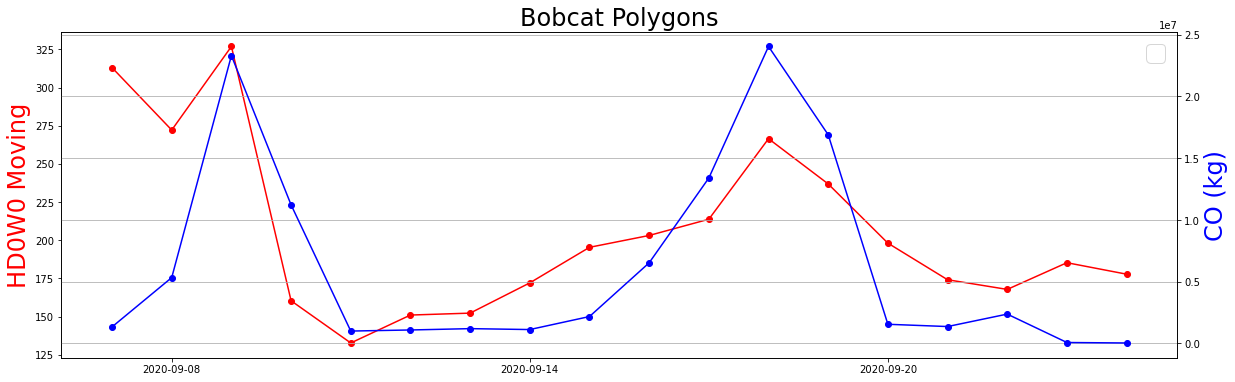

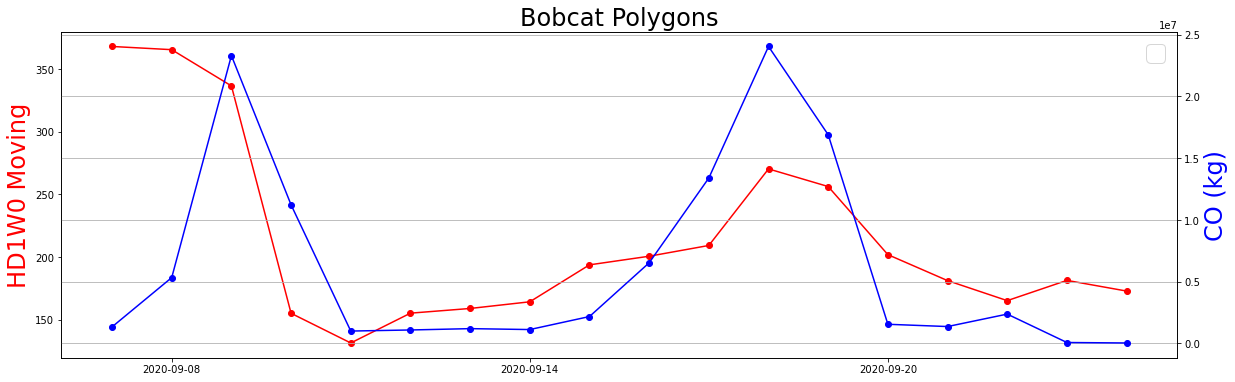

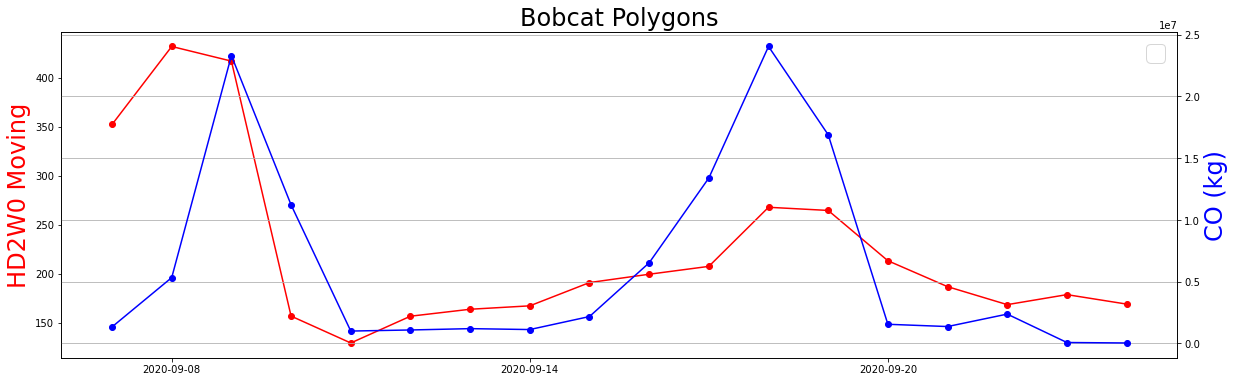

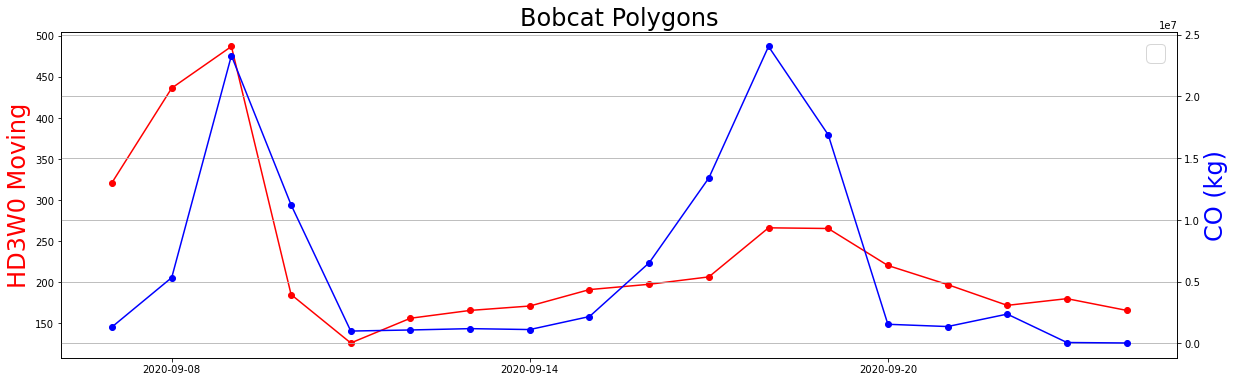

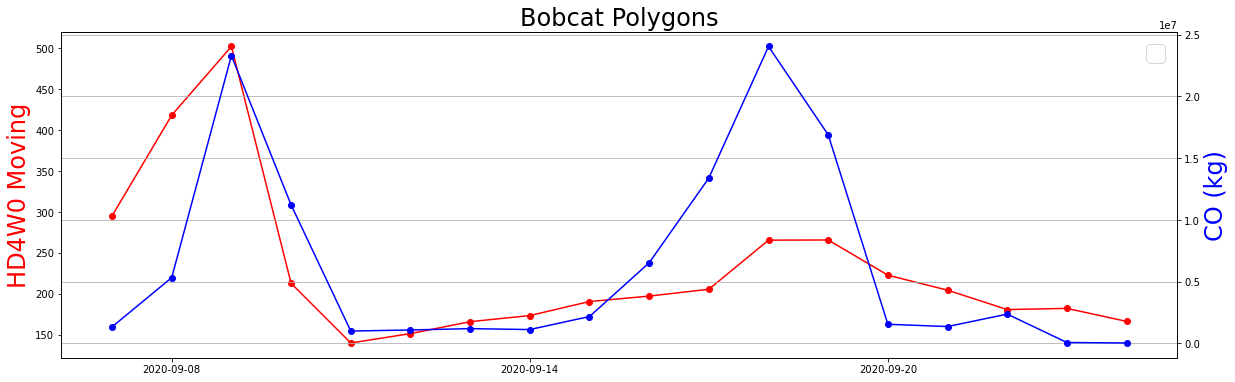

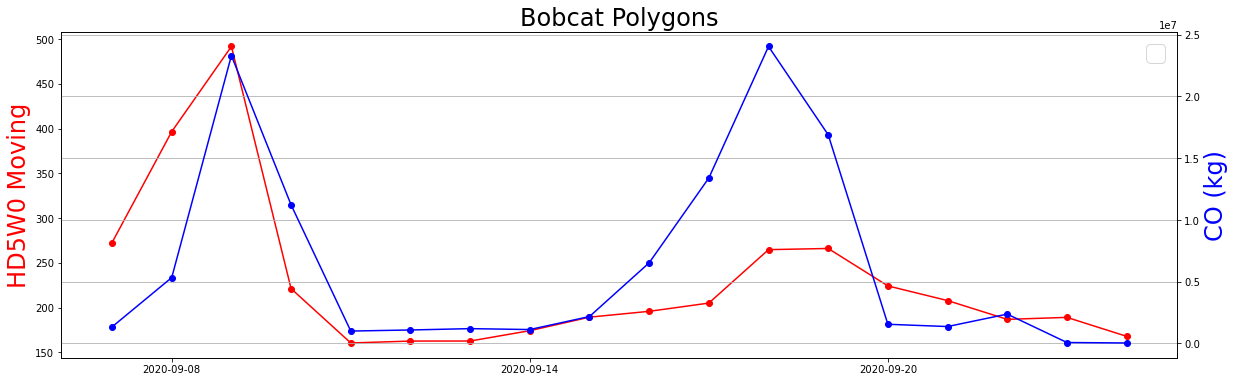

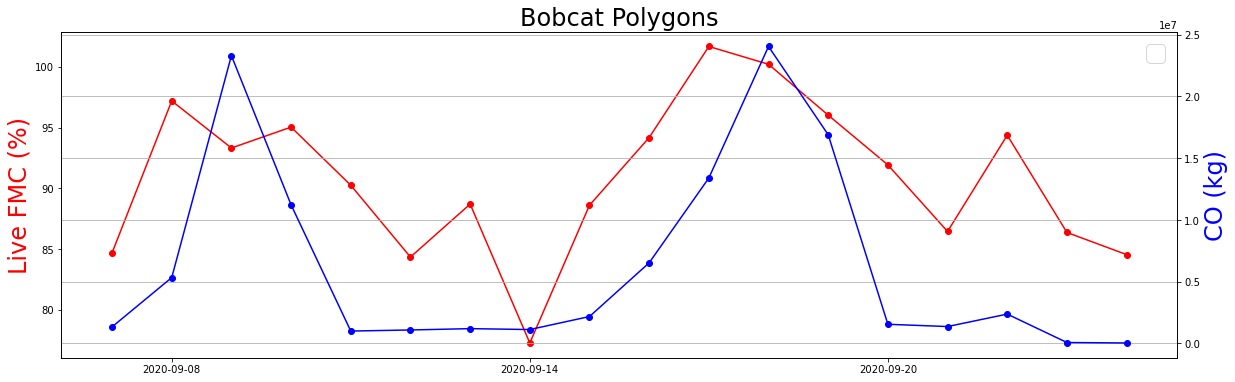

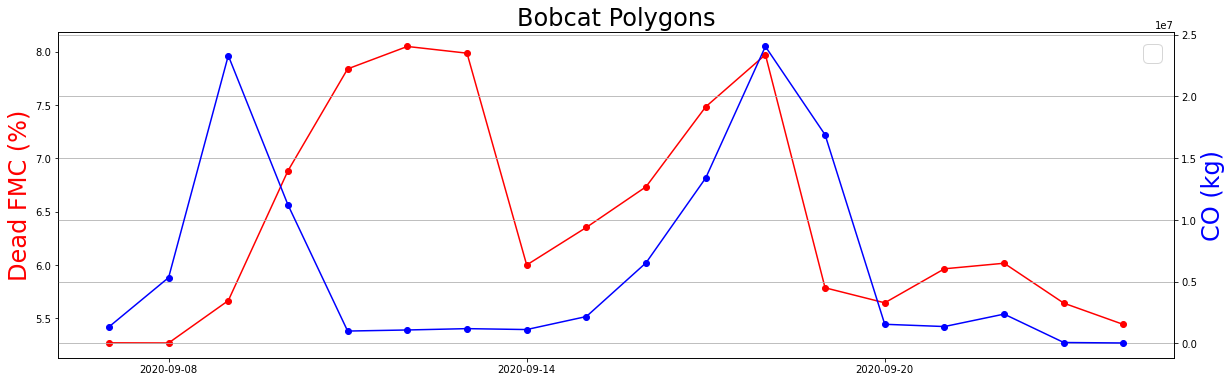

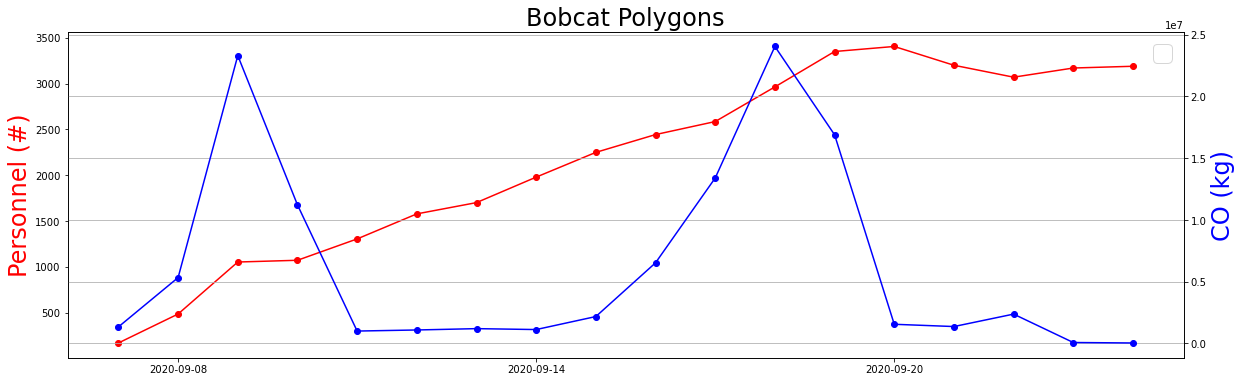

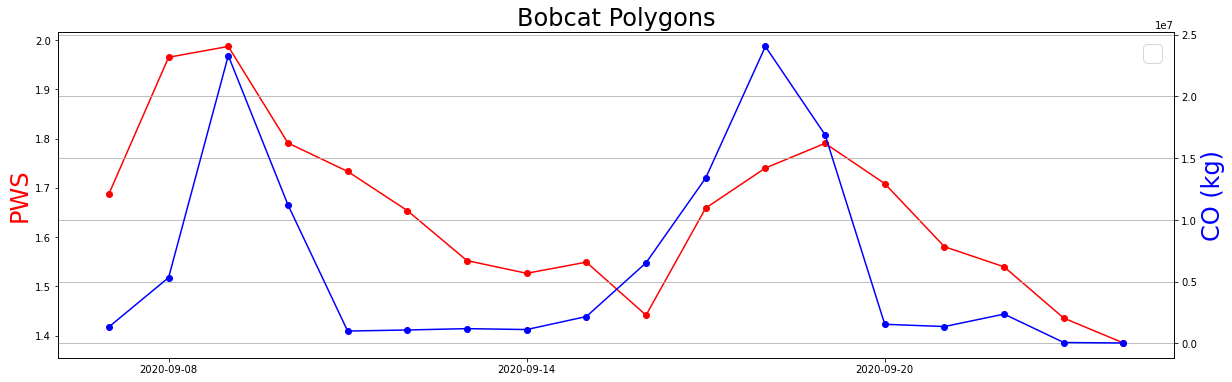

In [28]:
plot_twoline(df_merra['day'], np.stack([df_merra['temp'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Max Temperature (K)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['vpd'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Max VPD (hPa)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['wind'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Max Wind (m/s)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_merra['hd0w0'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Max HD0W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd1w0'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Max HD1W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd2w0'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Max HD2W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd3w0'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Max HD3W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd4w0'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Max HD4W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd5w0'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Max HD5W0', 'CO (kg)'], 1)

plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd0w0_MA'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['HD0W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd1w0_MA'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['HD1W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd2w0_MA'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['HD2W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd3w0_MA'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['HD3W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd4w0_MA'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['HD4W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd5w0_MA'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['HD5W0 Moving', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_ncar['mlive']*100, df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Live FMC (%)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_ncar['mdead']*100, df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Dead FMC (%)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_personnel['personnel'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['Personnel (#)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_pws['pws'], df_rave['CO']]), 'Bobcat Polygons',\
             [], ['PWS', 'CO (kg)'], 1)

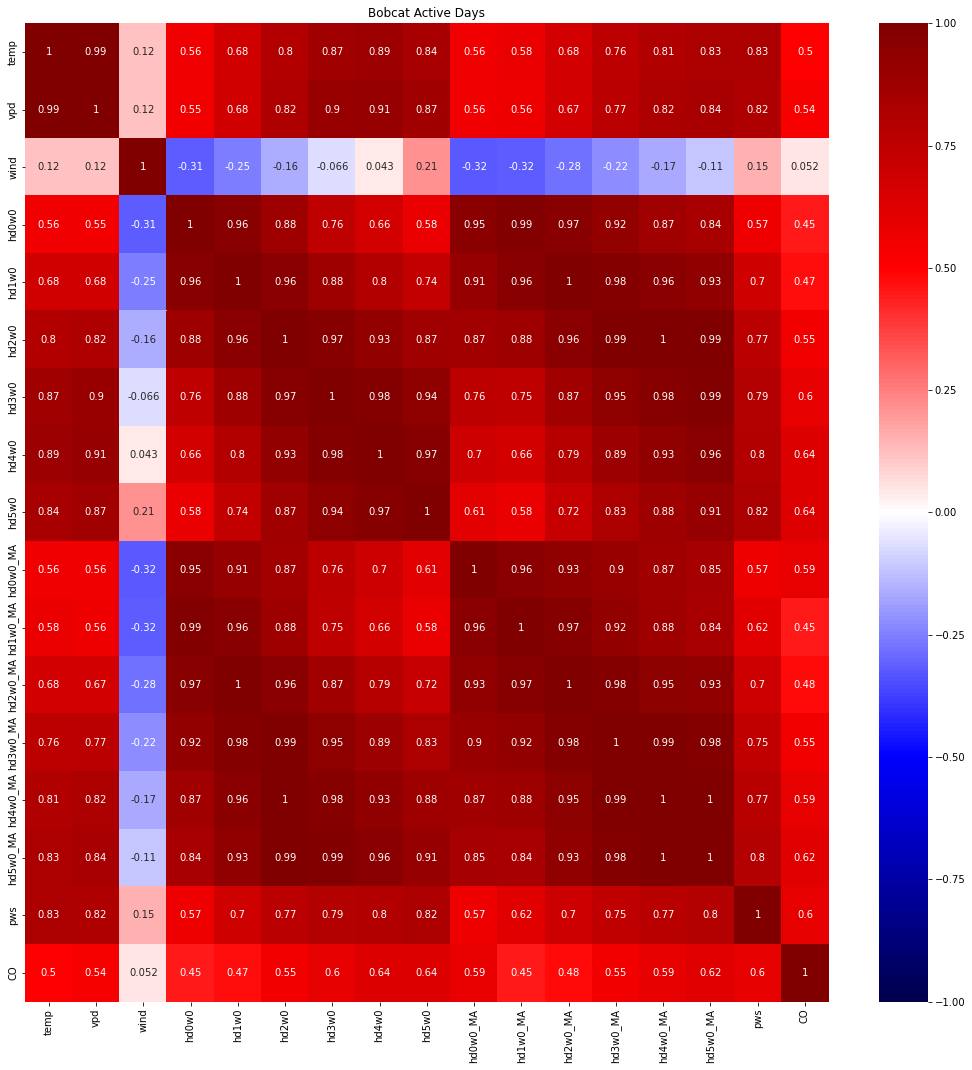

In [37]:
#concatenate all the dataframes
df_all = pd.concat([df_merra.drop(columns=['Unnamed: 0', 'frp', 'area', 'num points']),\
                    df_movingaverage.drop(columns=['Unnamed: 0','temp','vpd','wind', 'frp', 'area', 'num points']),\
                    #df_ncar.drop(columns=['Unnamed: 0']),\
                    #df_personnel.drop(columns=['Unnamed: 0']),\
                    df_pws.drop(columns=['Unnamed: 0']),\
                    df_rave['CO']], axis=1)
df_all
corrMatrix = df_all.corr()
fig,ax=plt.subplots(figsize=(18,18))
sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic')
plt.title('Bobcat Active Days')
plt.show()

## Holiday Farm

In [21]:
df_merra = pd.read_csv('HOLIDAY_FARM_Daily_MERRA.csv')
df_rave = pd.read_csv('HOLIDAY_FARM_Daily_RAVE.csv')
df_ncar = pd.read_csv('HOLIDAY_FARM_Daily_NCAR_Moisture.csv')
df_personnel = pd.read_csv('HOLIDAY_FARM_Daily_Personnel.csv')
df_pws = pd.read_csv('HOLIDAY_FARM_Daily_PWS.csv')

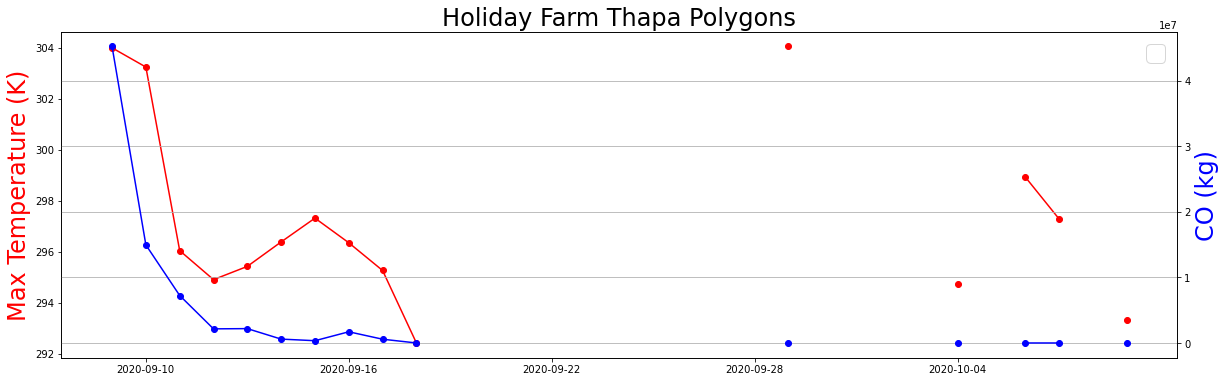

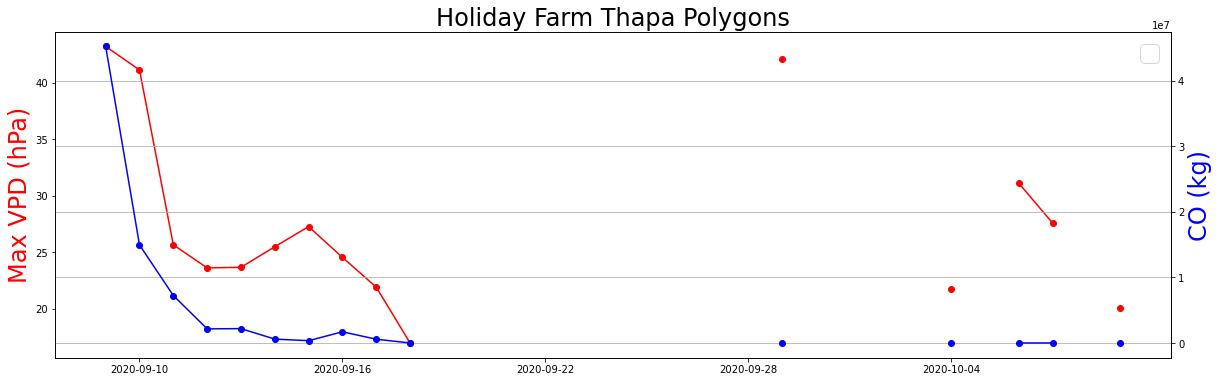

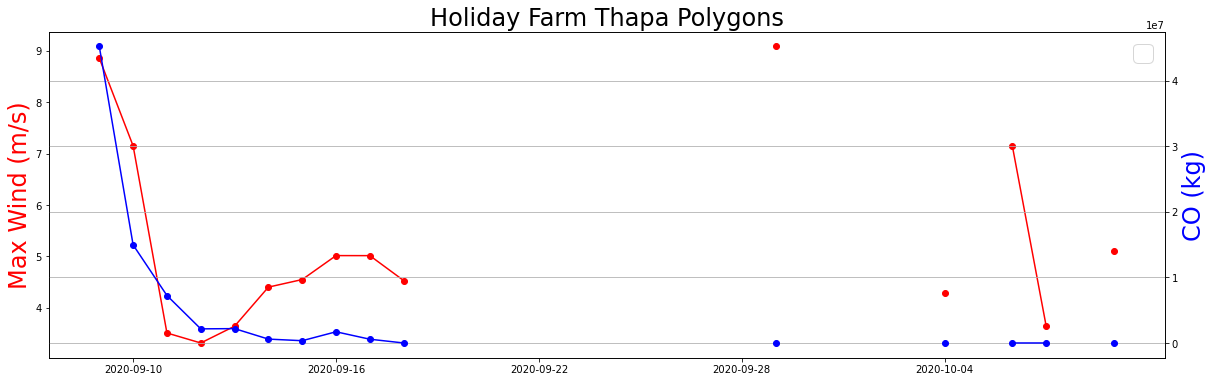

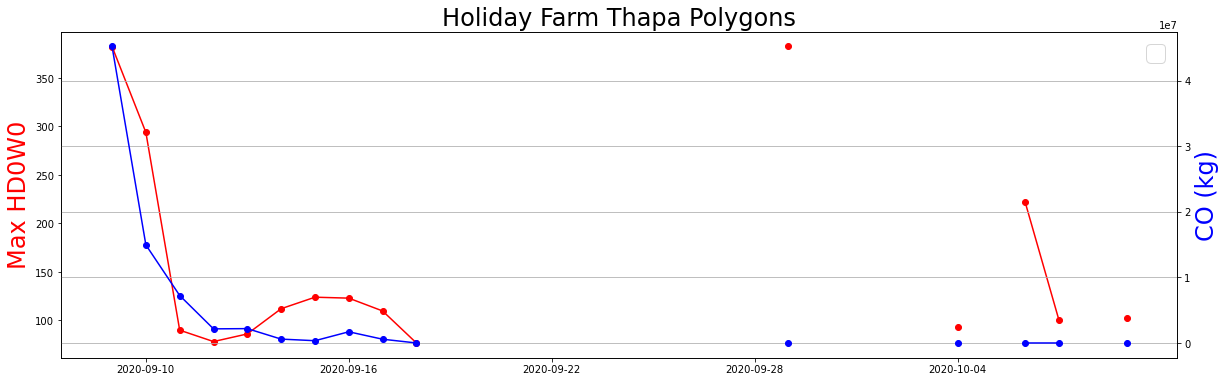

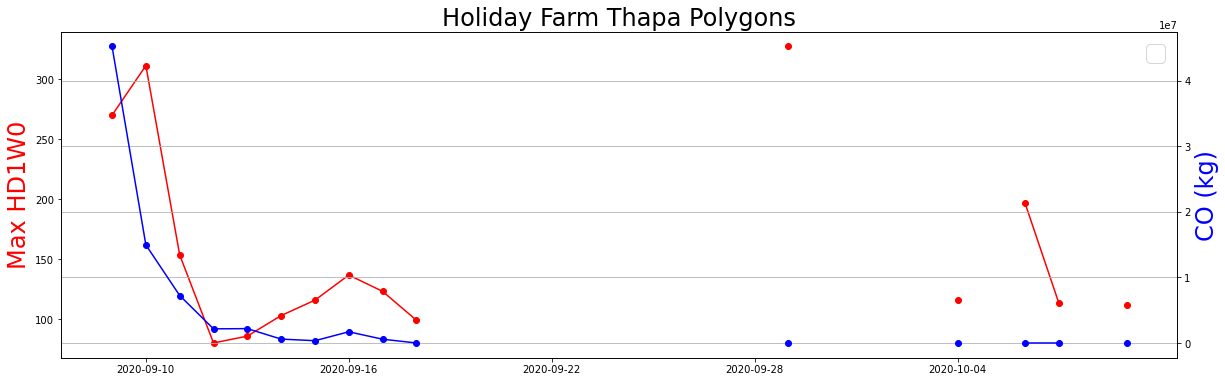

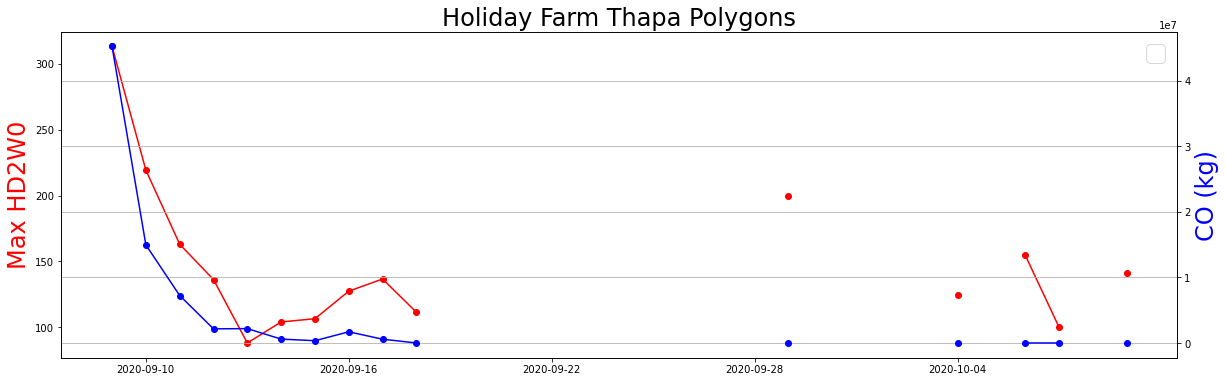

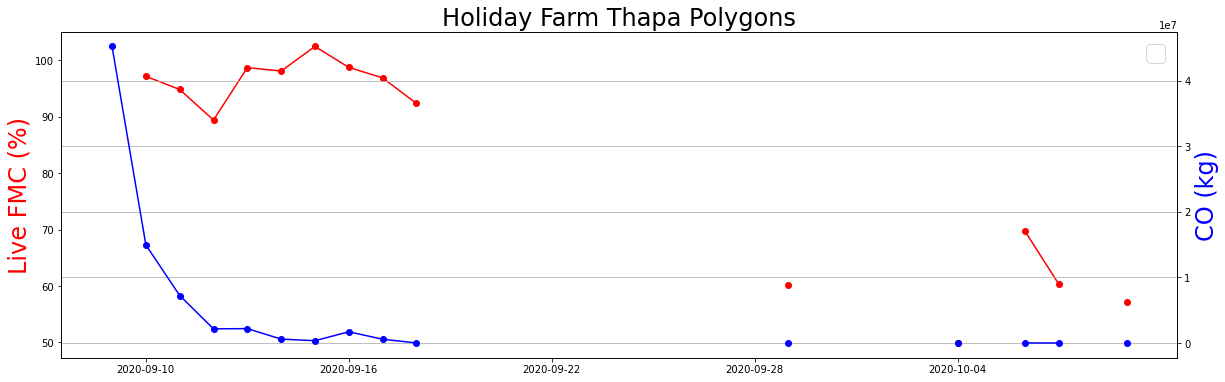

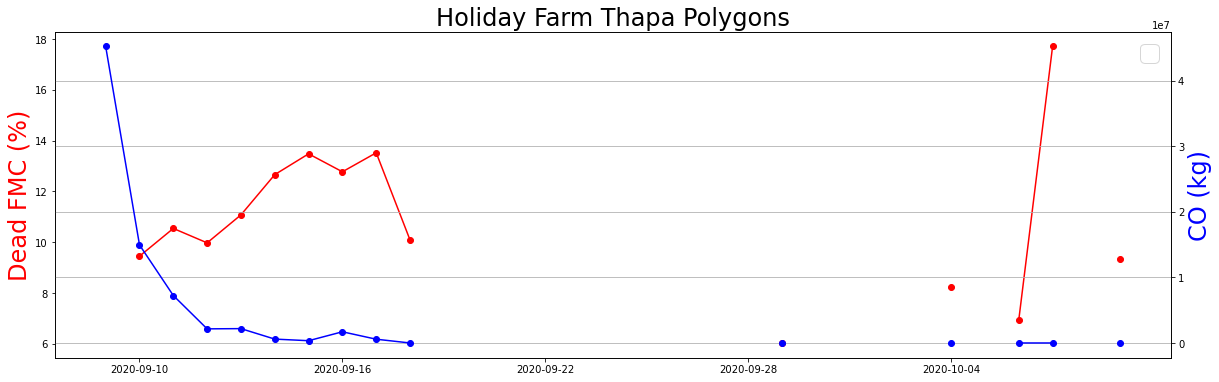

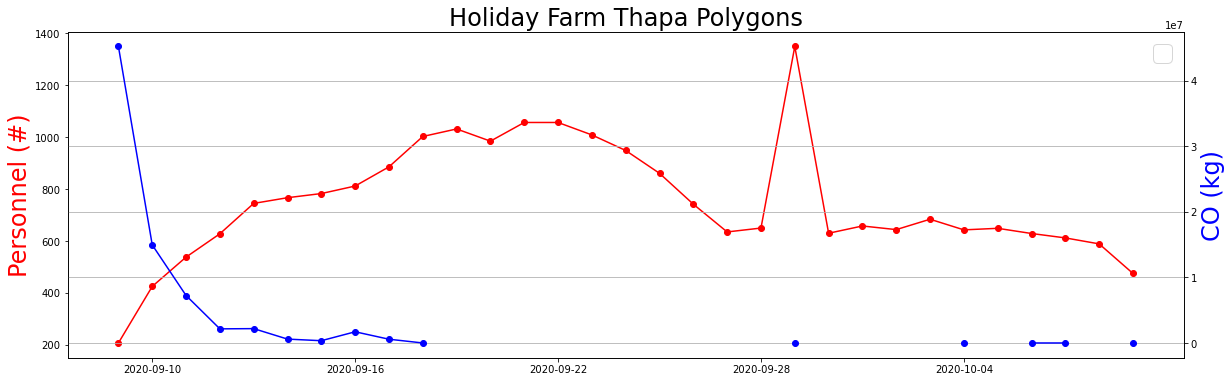

ValueError: all input arrays must have the same shape

In [22]:
plot_twoline(df_merra['day'], np.stack([df_merra['temp'], df_rave['CO']]), 'Holiday Farm Thapa Polygons',\
             [], ['Max Temperature (K)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['vpd'], df_rave['CO']]), 'Holiday Farm Thapa Polygons',\
             [], ['Max VPD (hPa)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['wind'], df_rave['CO']]), 'Holiday Farm Thapa Polygons',\
             [], ['Max Wind (m/s)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_merra['hd0w0'], df_rave['CO']]), 'Holiday Farm Thapa Polygons',\
             [], ['Max HD0W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd1w0'], df_rave['CO']]), 'Holiday Farm Thapa Polygons',\
             [], ['Max HD1W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd2w0'], df_rave['CO']]), 'Holiday Farm Thapa Polygons',\
             [], ['Max HD2W0', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_ncar['mlive']*100, df_rave['CO']]), 'Holiday Farm Thapa Polygons',\
             [], ['Live FMC (%)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_ncar['mdead']*100, df_rave['CO']]), 'Holiday Farm Thapa Polygons',\
             [], ['Dead FMC (%)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_personnel['personnel'], df_rave['CO']]), 'Holiday Farm Thapa Polygons',\
             [], ['Personnel (#)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_pws['pws'], df_rave['CO']]), 'Holiday Farm  Thapa Polygons',\
             [], ['PWS', 'CO (kg)'], 1)

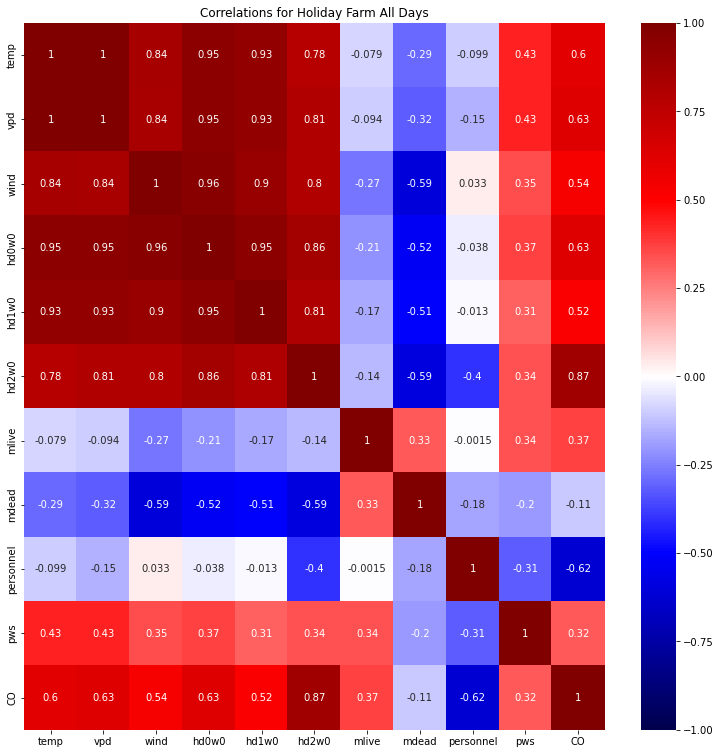

In [23]:
#concatenate all the dataframes
df_all = pd.concat([df_merra.drop(columns=['Unnamed: 0', 'frp', 'area', 'num points']),\
                    df_ncar.drop(columns=['Unnamed: 0']),\
                    df_personnel.drop(columns=['Unnamed: 0']),\
                    df_pws.drop(columns=['Unnamed: 0']),\
                    df_rave['CO']], axis=1)
df_all
corrMatrix = df_all.corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic')
plt.title('Correlations for Holiday Farm All Days')
plt.show()

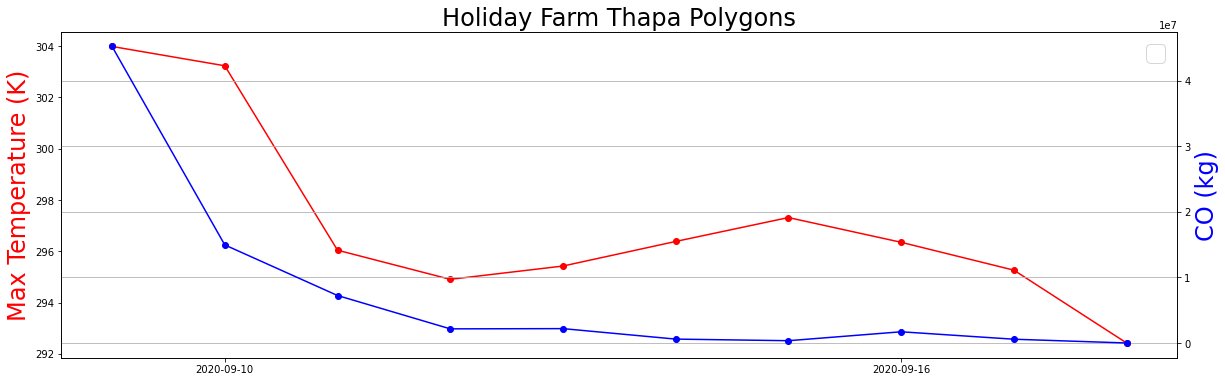

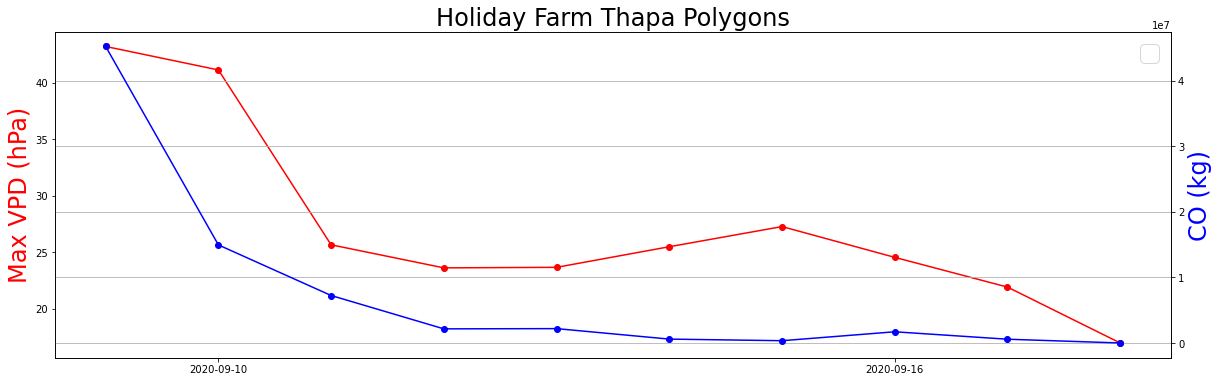

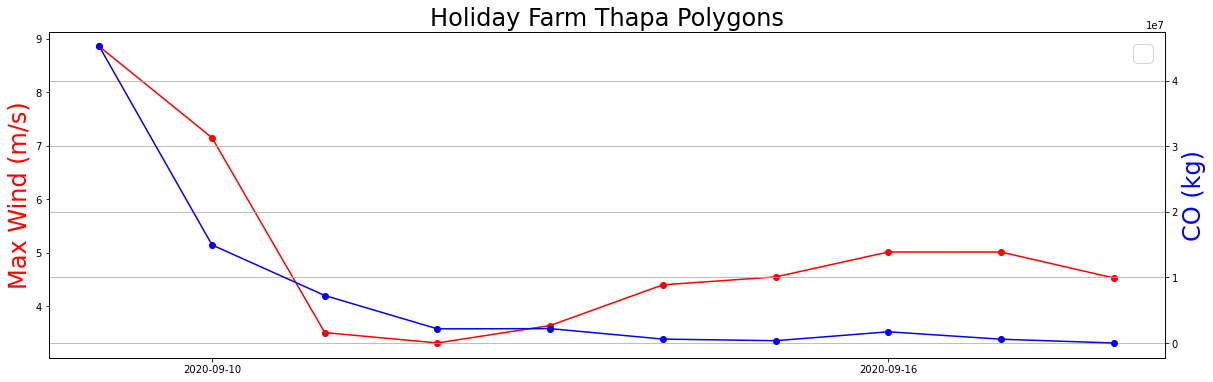

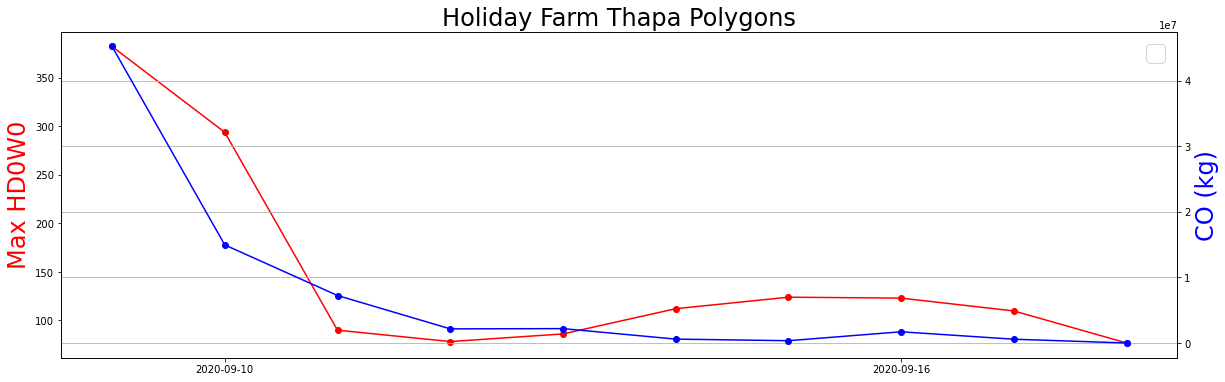

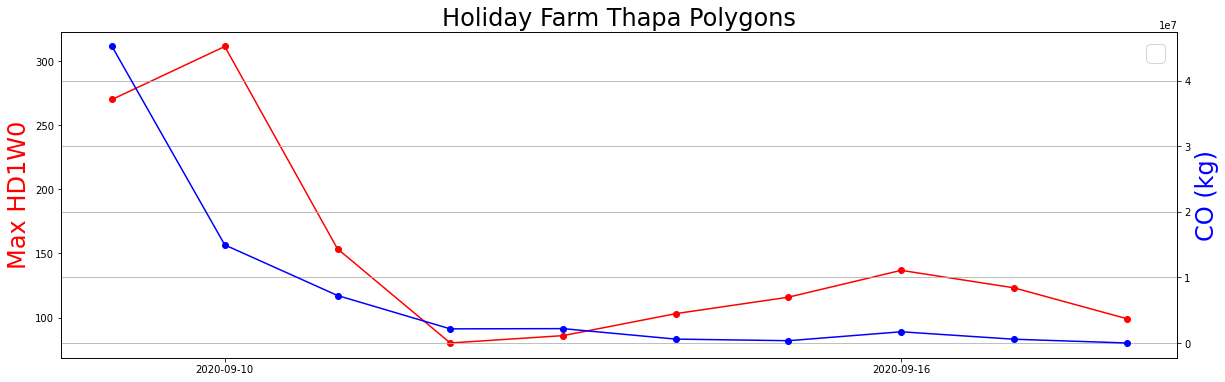

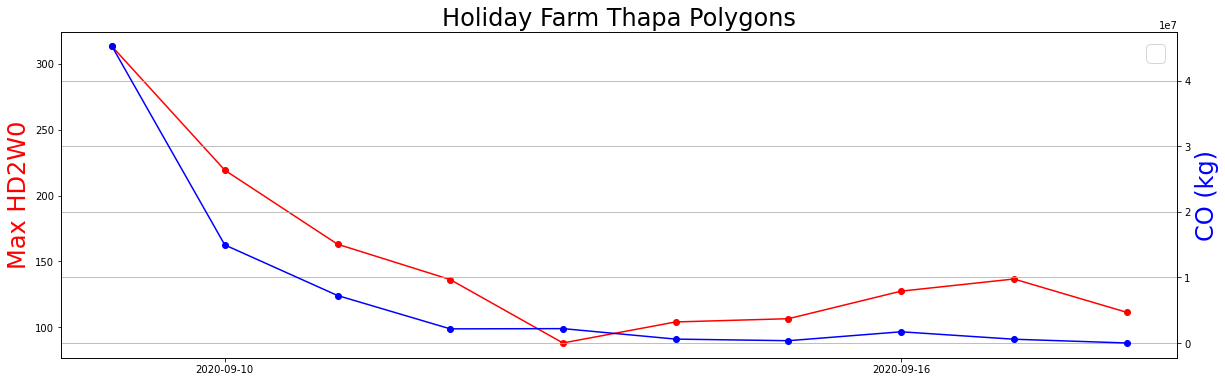

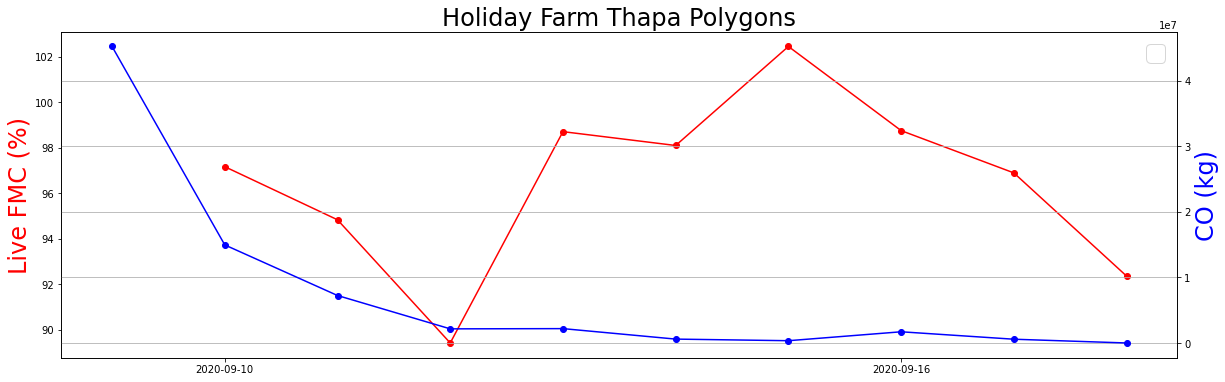

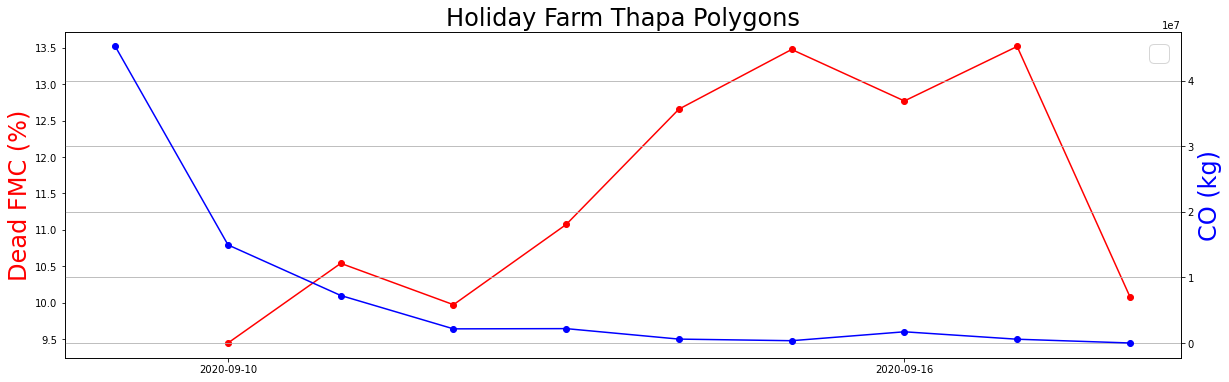

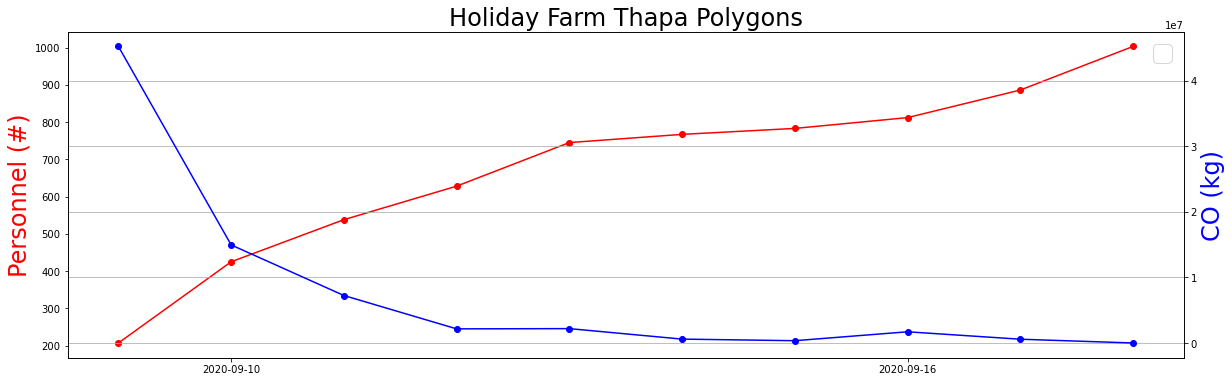

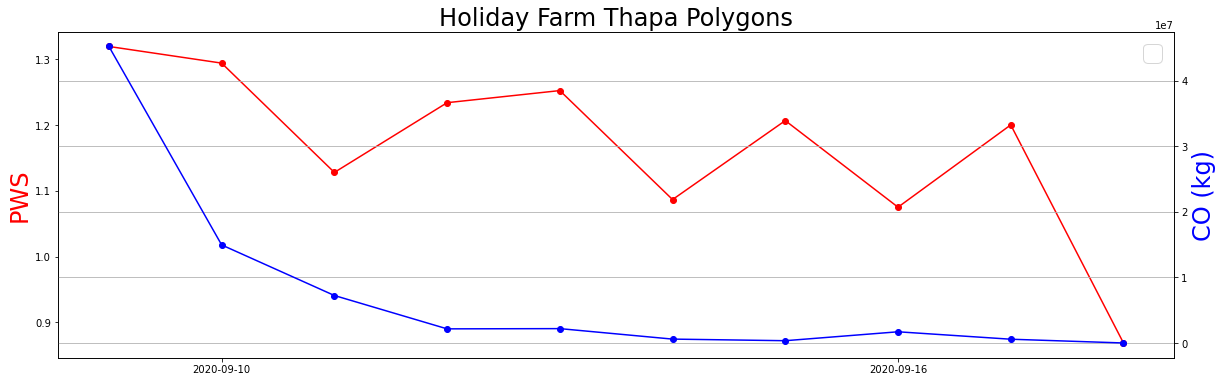

In [24]:
# find the most active days


plot_twoline(df_merra['day'].iloc[0:10], np.stack([df_merra['temp'].iloc[0:10], df_rave['CO'].iloc[0:10]]), 'Holiday Farm Thapa Polygons',\
             [], ['Max Temperature (K)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'].iloc[0:10], np.stack([df_merra['vpd'].iloc[0:10], df_rave['CO'].iloc[0:10]]), 'Holiday Farm Thapa Polygons',\
             [], ['Max VPD (hPa)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'].iloc[0:10], np.stack([df_merra['wind'].iloc[0:10], df_rave['CO'].iloc[0:10]]), 'Holiday Farm Thapa Polygons',\
             [], ['Max Wind (m/s)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'].iloc[0:10], np.stack([df_merra['hd0w0'].iloc[0:10], df_rave['CO'].iloc[0:10]]), 'Holiday Farm Thapa Polygons',\
             [], ['Max HD0W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'].iloc[0:10], np.stack([df_merra['hd1w0'].iloc[0:10], df_rave['CO'].iloc[0:10]]), 'Holiday Farm Thapa Polygons',\
             [], ['Max HD1W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'].iloc[0:10], np.stack([df_merra['hd2w0'].iloc[0:10], df_rave['CO'].iloc[0:10]]), 'Holiday Farm Thapa Polygons',\
             [], ['Max HD2W0', 'CO (kg)'], 1)

plot_twoline(df_merra['day'].iloc[0:10], np.stack([df_ncar['mlive'].iloc[0:10]*100, df_rave['CO'].iloc[0:10]]), 'Holiday Farm Thapa Polygons',\
             [], ['Live FMC (%)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'].iloc[0:10], np.stack([df_ncar['mdead'].iloc[0:10]*100, df_rave['CO'].iloc[0:10]]), 'Holiday Farm Thapa Polygons',\
             [], ['Dead FMC (%)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'].iloc[0:10], np.stack([df_personnel['personnel'].iloc[0:10], df_rave['CO'].iloc[0:10]]), 'Holiday Farm Thapa Polygons',\
             [], ['Personnel (#)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'].iloc[0:10], np.stack([df_pws['pws'].iloc[0:10], df_rave['CO'].iloc[0:10]]), 'Holiday Farm Thapa Polygons',\
             [], ['PWS', 'CO (kg)'], 1)

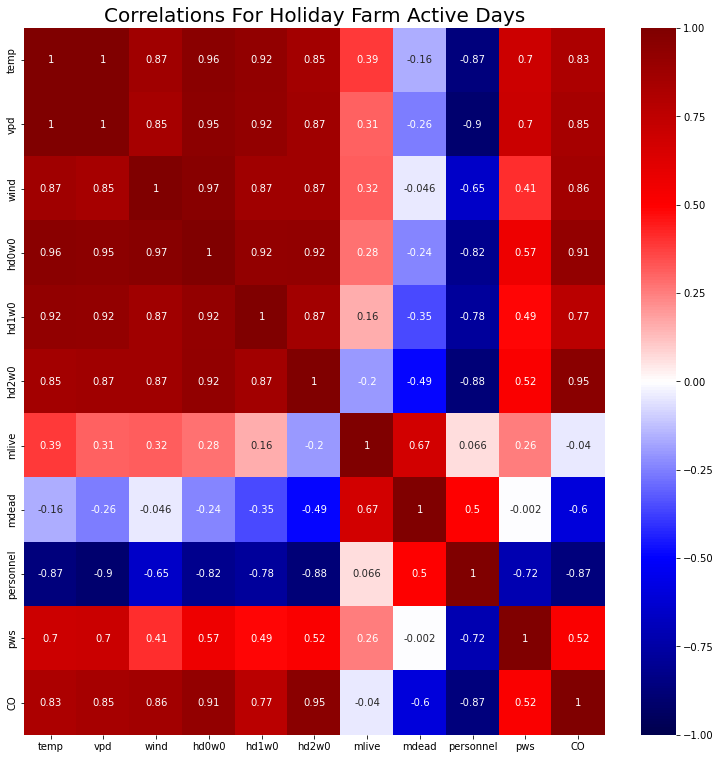

In [30]:
#concatenate all the dataframes
df_all = pd.concat([df_merra.iloc[0:10].drop(columns=['Unnamed: 0', 'frp', 'area', 'num points']),\
                    df_ncar.iloc[0:10].drop(columns=['Unnamed: 0']),\
                    df_personnel.iloc[0:10].drop(columns=['Unnamed: 0']),\
                    df_pws.iloc[0:10].drop(columns=['Unnamed: 0']),\
                    df_rave['CO'].iloc[0:10]], axis=1)
corrMatrix = df_all.corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic')
plt.title('Correlations For Holiday Farm Active Days', fontsize=20)

plt.show()

## Dolan

In [39]:
df_merra = pd.read_csv('DOLAN_Daily_MERRA.csv').iloc[0:30]
df_rave = pd.read_csv('DOLAN_Daily_RAVE.csv').iloc[0:30]
df_ncar = pd.read_csv('DOLAN_Daily_NCAR_Moisture.csv').iloc[0:30]
df_personnel = pd.read_csv('DOLAN_Daily_Personnel.csv').iloc[0:30]
df_pws = pd.read_csv('DOLAN_Daily_PWS.csv').iloc[0:30]
df_movingaverage = pd.read_csv('DOLAN_Daily_MERRA_movingaverage.csv').iloc[0:30]


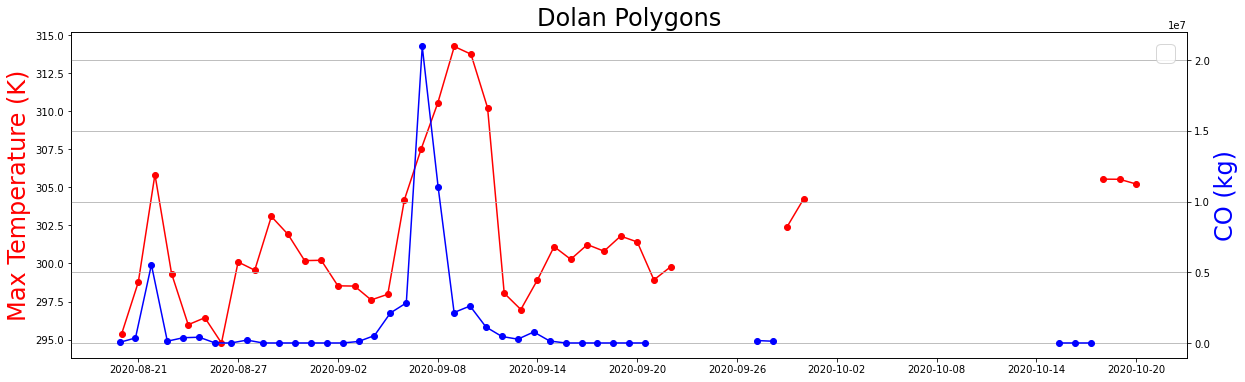

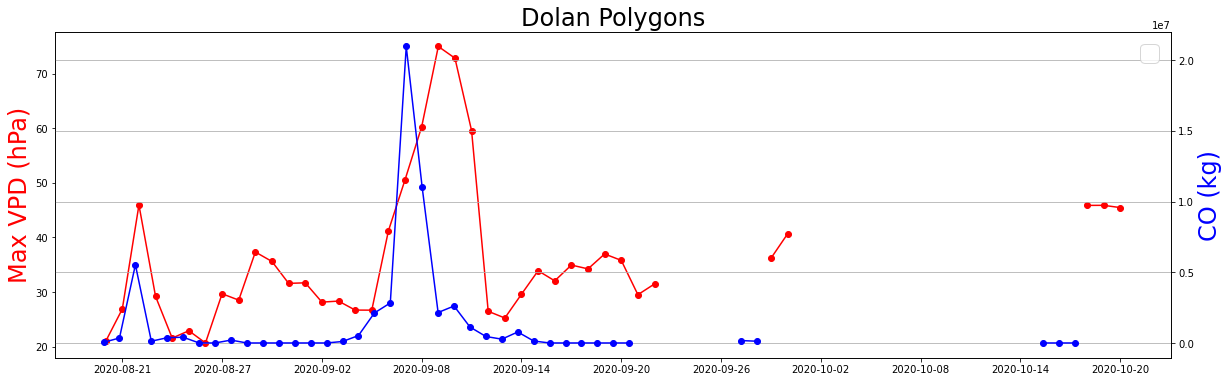

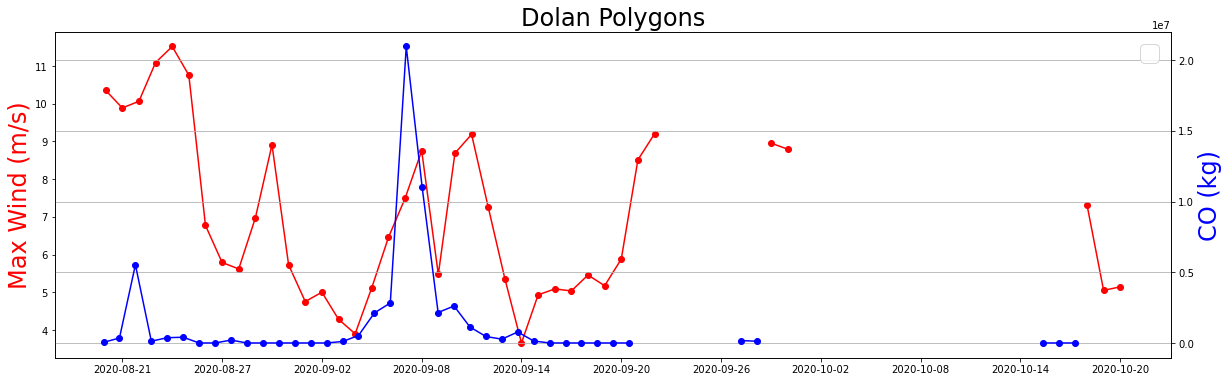

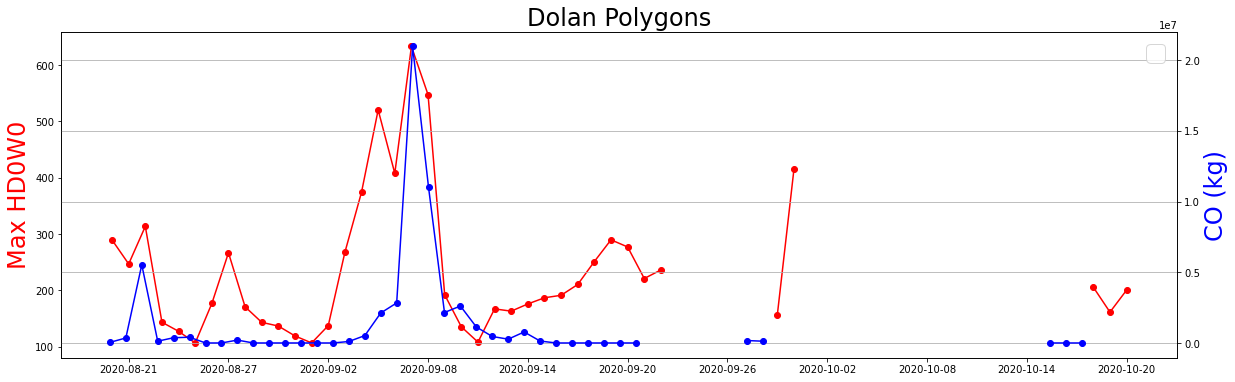

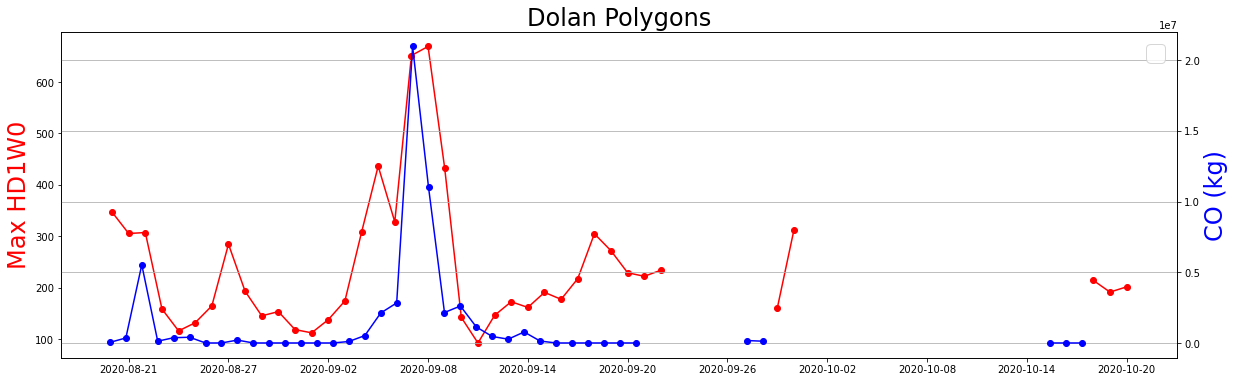

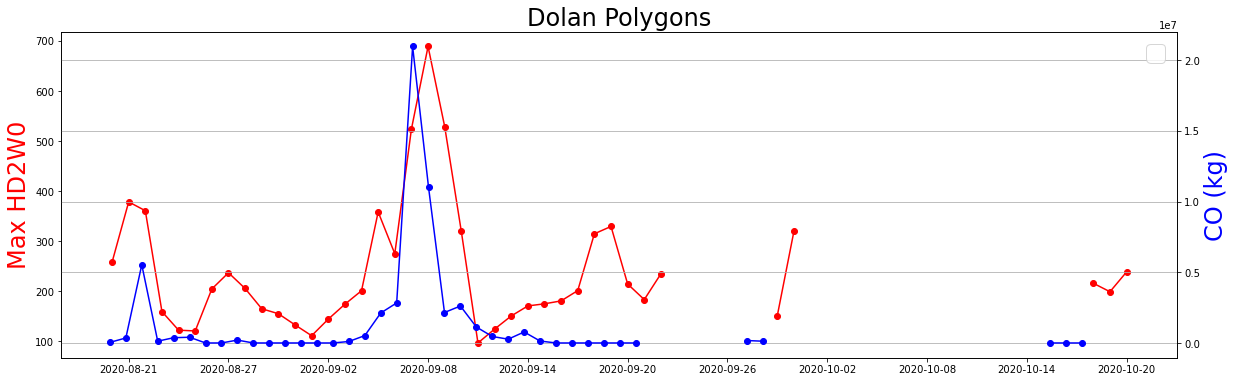

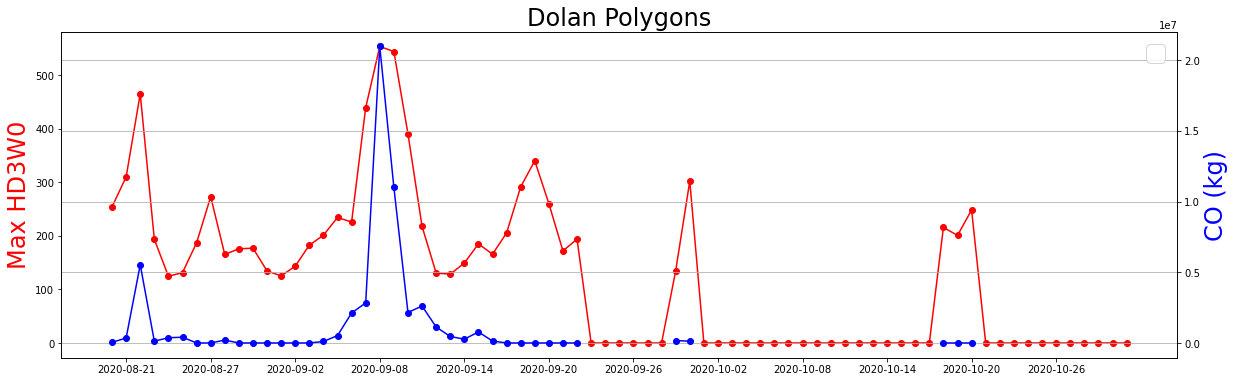

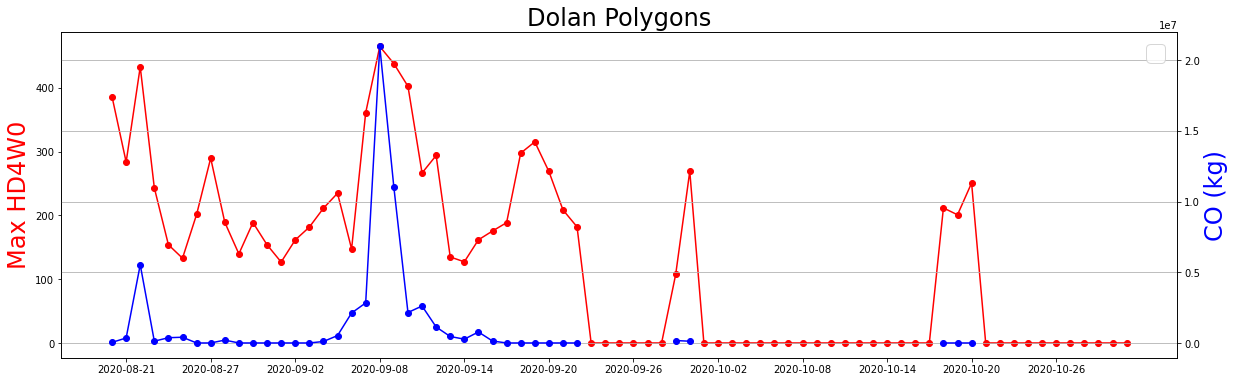

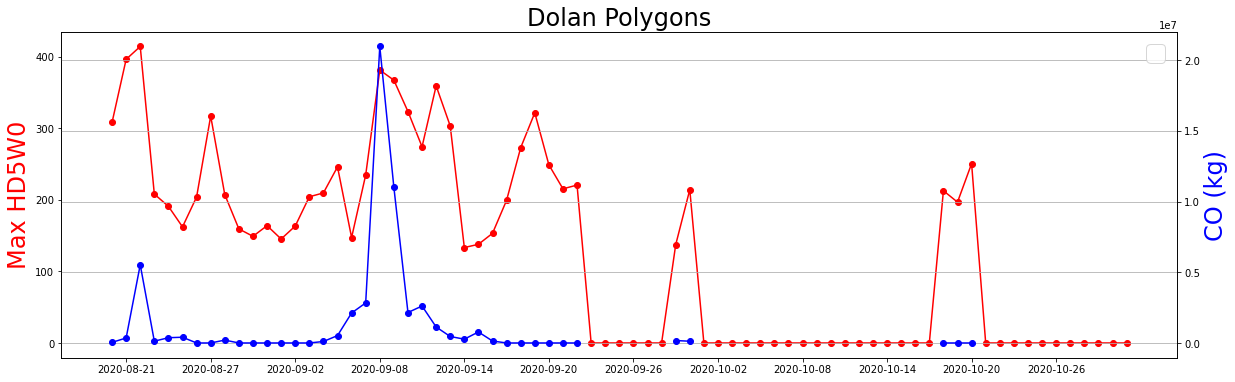

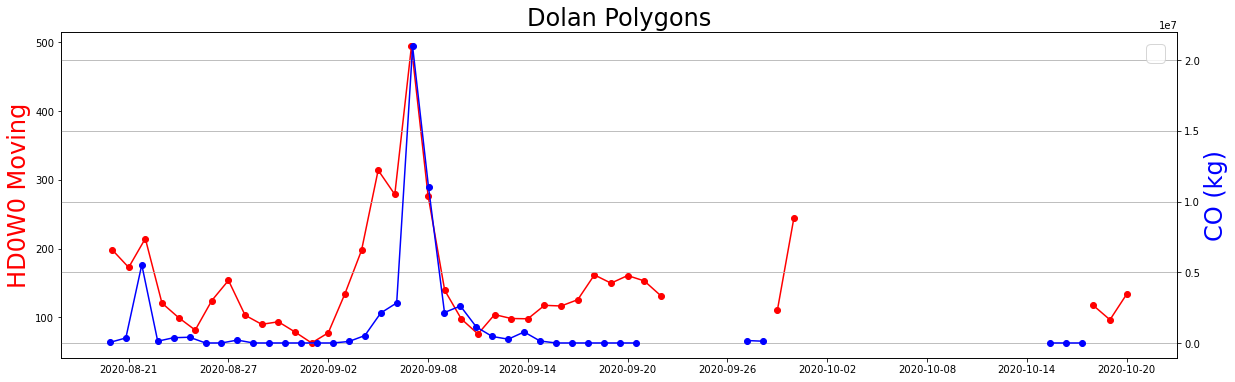

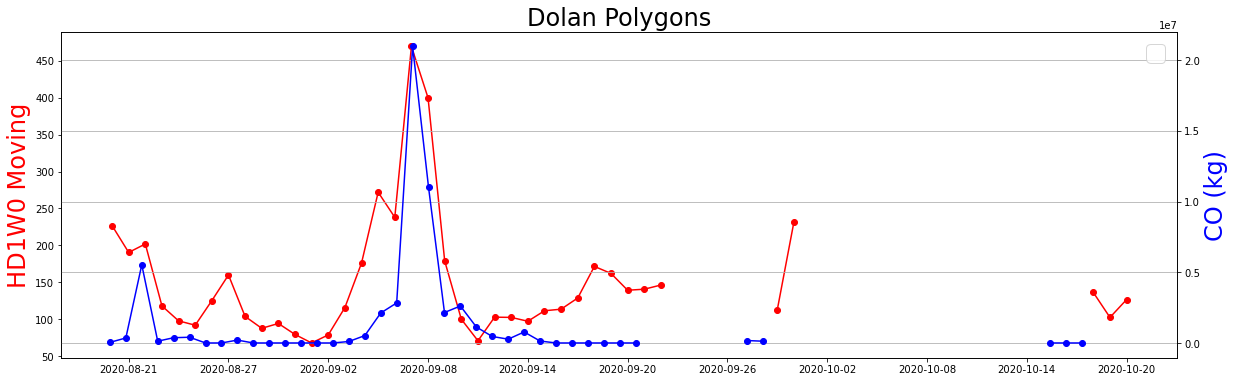

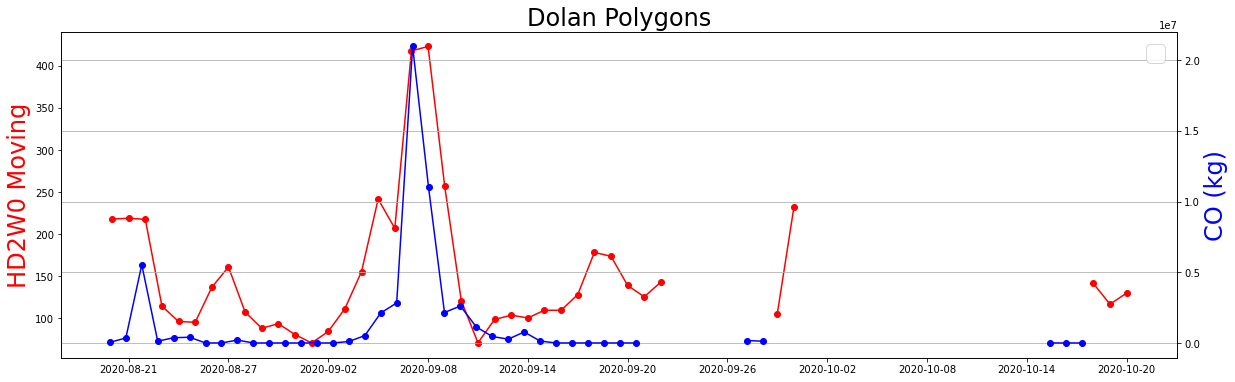

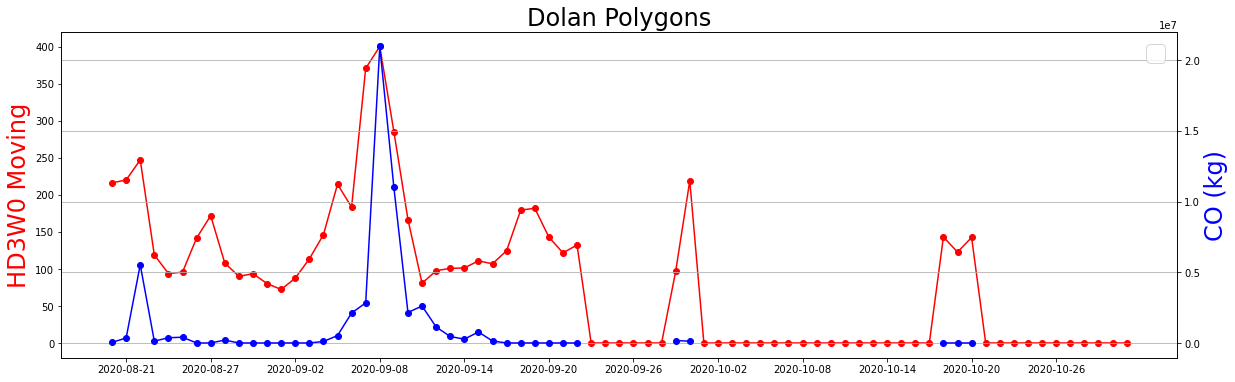

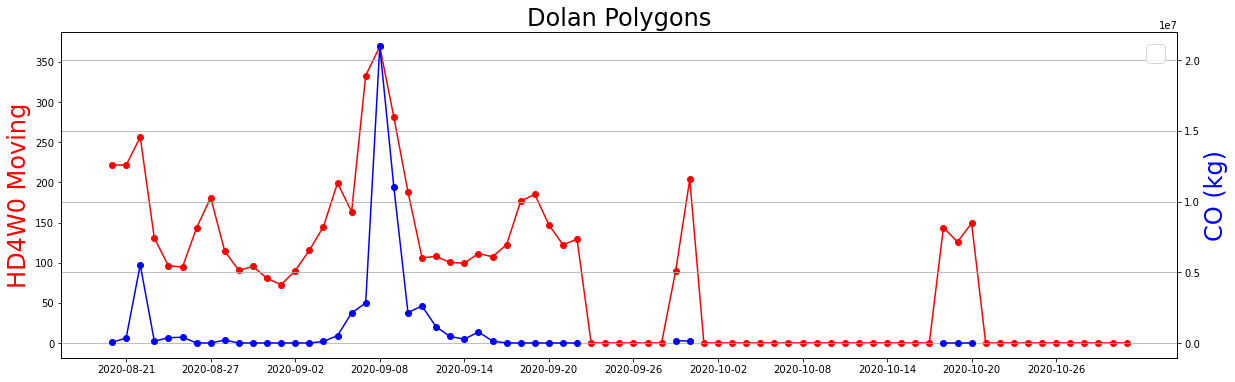

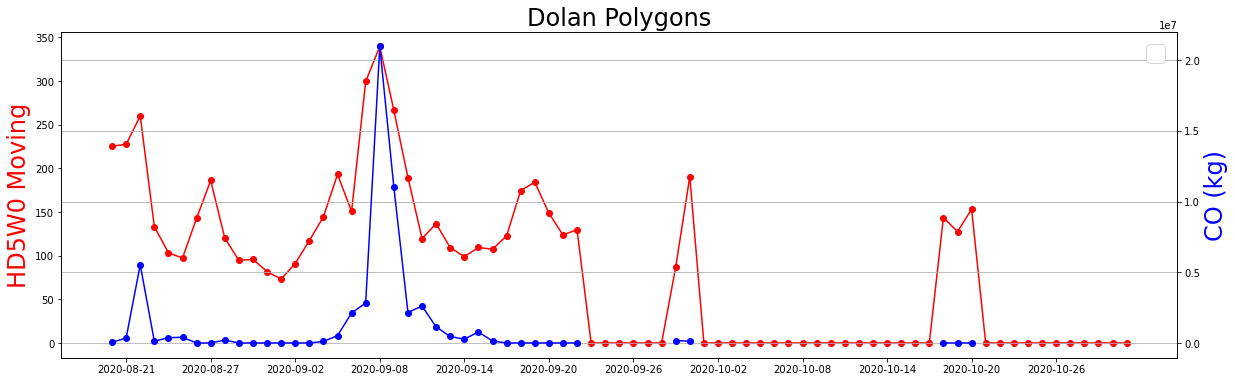

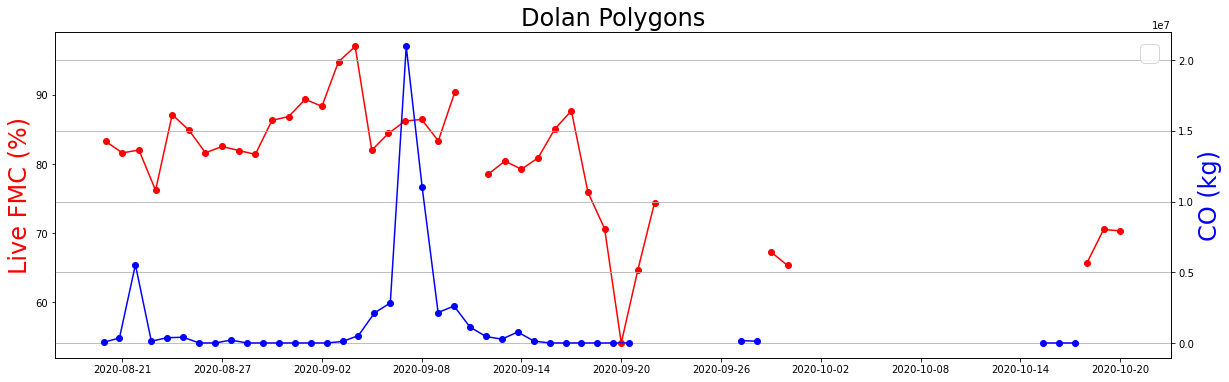

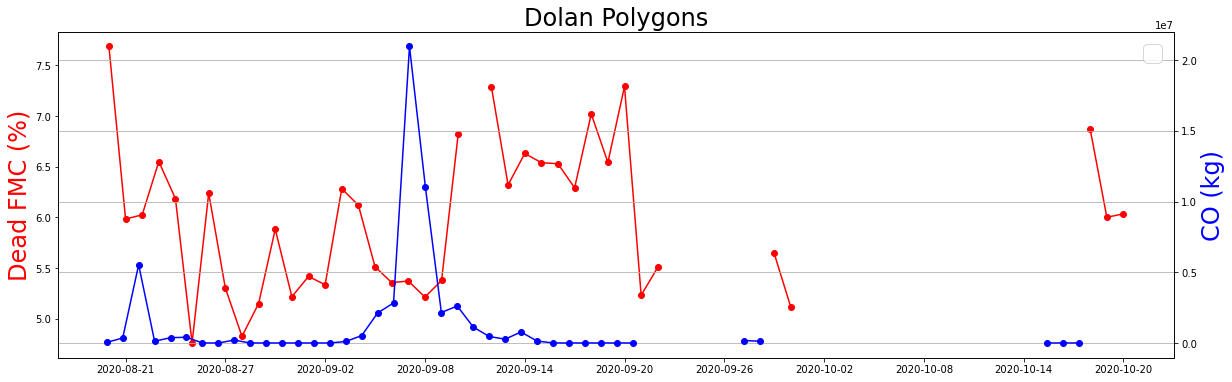

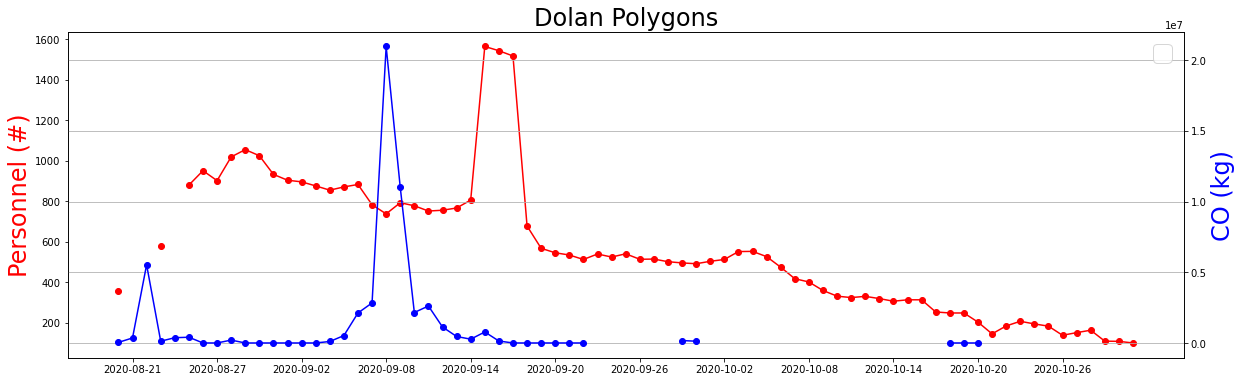

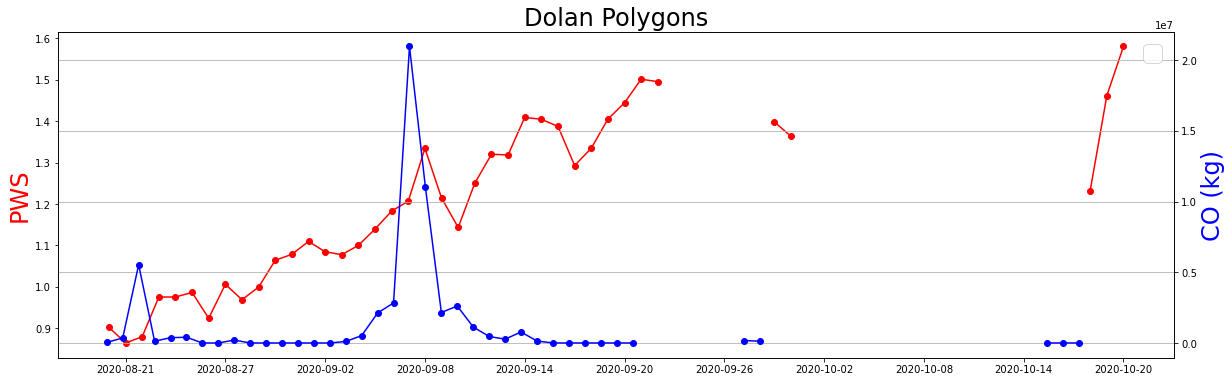

In [40]:
plot_twoline(df_merra['day'], np.stack([df_merra['temp'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['Max Temperature (K)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['vpd'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['Max VPD (hPa)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['wind'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['Max Wind (m/s)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_merra['hd0w0'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['Max HD0W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd1w0'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['Max HD1W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd2w0'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['Max HD2W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd3w0'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['Max HD3W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd4w0'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['Max HD4W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_merra['hd5w0'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['Max HD5W0', 'CO (kg)'], 1)

plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd0w0_MA'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['HD0W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd1w0_MA'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['HD1W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd2w0_MA'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['HD2W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd3w0_MA'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['HD3W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd4w0_MA'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['HD4W0 Moving', 'CO (kg)'], 1)
plot_twoline(df_movingaverage['day'], np.stack([df_movingaverage['hd5w0_MA'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['HD5W0 Moving', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_ncar['mlive']*100, df_rave['CO']]), 'Dolan Polygons',\
             [], ['Live FMC (%)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_ncar['mdead']*100, df_rave['CO']]), 'Dolan Polygons',\
             [], ['Dead FMC (%)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_personnel['personnel'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['Personnel (#)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'], np.stack([df_pws['pws'], df_rave['CO']]), 'Dolan Polygons',\
             [], ['PWS', 'CO (kg)'], 1)

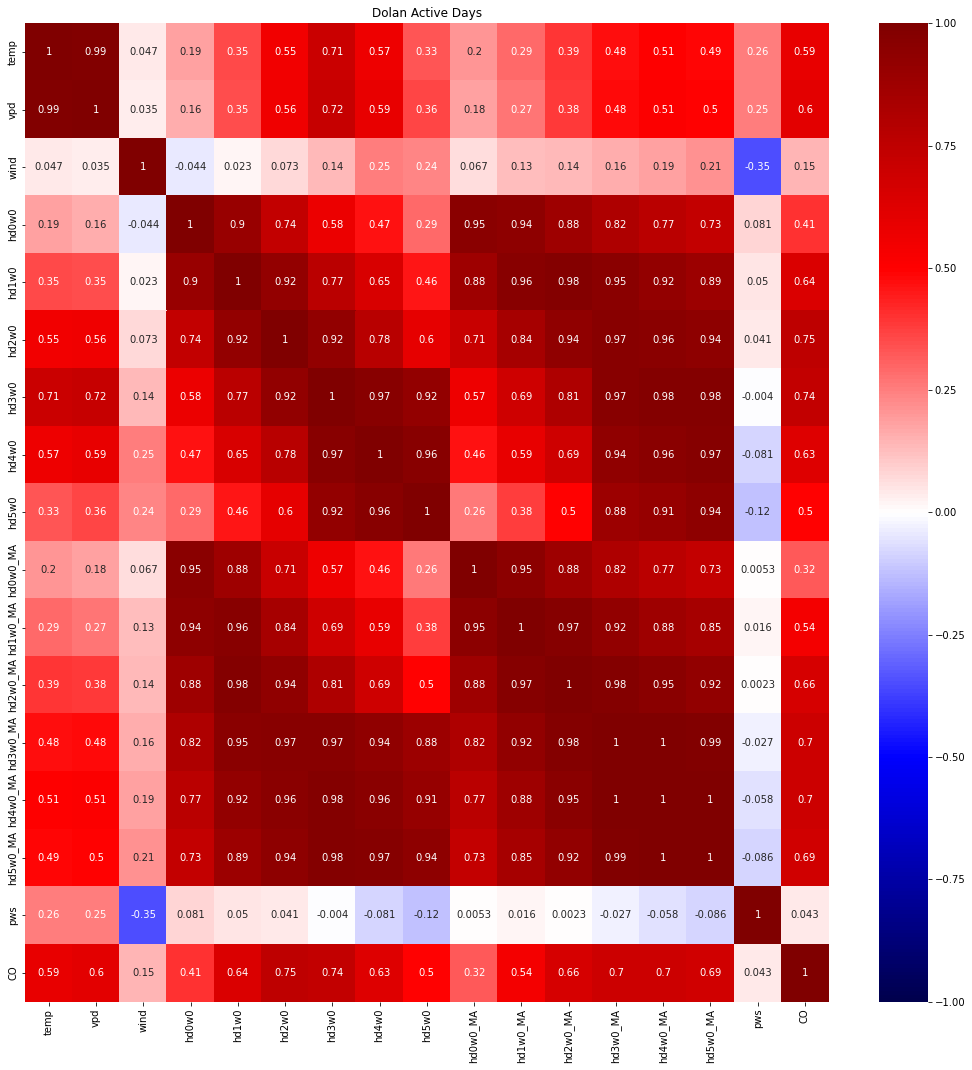

In [41]:
#concatenate all the dataframes
df_all = pd.concat([df_merra.drop(columns=['Unnamed: 0', 'frp', 'area', 'num points']),\
                    df_movingaverage.drop(columns=['Unnamed: 0','temp','vpd','wind', 'frp', 'area', 'num points']),\
                    #df_ncar.drop(columns=['Unnamed: 0']),\
                    #df_personnel.drop(columns=['Unnamed: 0']),\
                    df_pws.drop(columns=['Unnamed: 0']),\
                    df_rave['CO']], axis=1)
df_all
corrMatrix = df_all.corr()
fig,ax=plt.subplots(figsize=(18,18))
sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic')
plt.title('Dolan Active Days')
plt.show()

## Look at all 3 fires

In [34]:
df_merra = pd.concat([pd.read_csv('AC_Daily_MERRA.csv').iloc[1:50], pd.read_csv('BOBCAT_Daily_MERRA.csv').iloc[1:18],pd.read_csv('HOLIDAY_FARM_Daily_MERRA.csv').iloc[1:10]], axis=0, ignore_index=True)
df_rave = pd.concat([pd.read_csv('AC_Daily_RAVE.csv').iloc[1:50], pd.read_csv('BOBCAT_Daily_RAVE.csv').iloc[1:18],pd.read_csv('HOLIDAY_FARM_Daily_RAVE.csv').iloc[1:10]], axis=0, ignore_index=True)
df_ncar = pd.concat([pd.read_csv('AC_Daily_NCAR_Moisture.csv').iloc[1:50], pd.read_csv('BOBCAT_Daily_NCAR_Moisture.csv').iloc[1:18],pd.read_csv('HOLIDAY_FARM_Daily_NCAR_Moisture.csv').iloc[1:10]], axis=0, ignore_index=True)
df_personnel = pd.concat([pd.read_csv('AC_Daily_Personnel.csv').iloc[1:50], pd.read_csv('BOBCAT_Daily_Personnel.csv').iloc[1:18],pd.read_csv('HOLIDAY_FARM_Daily_Personnel.csv').iloc[1:10]], axis=0, ignore_index=True)
df_pws = pd.concat([pd.read_csv('AC_Daily_PWS.csv').iloc[1:50], pd.read_csv('BOBCAT_Daily_PWS.csv').iloc[1:18],pd.read_csv('HOLIDAY_FARM_Daily_PWS.csv').iloc[1:10]], axis=0, ignore_index=True)

In [35]:
df_merra

Unnamed: 0         day        temp        vpd      wind       hd0w0  \
0            1  2020-08-19  310.542756  60.195318  7.752358  466.655670   
1            2  2020-08-20  305.892482  47.640143  8.362830  398.406416   
2            3  2020-08-21  303.102997  37.293854  5.782452  215.649922   
3            4  2020-08-22  303.997819  40.903493  6.135851  250.977727   
4            5  2020-08-23  306.491485  49.796687  4.034532  200.906347   
..         ...         ...         ...        ...       ...         ...   
70           5  2020-09-14  296.385384  25.473000  4.402404  112.142433   
71           6  2020-09-15  297.317500  27.255678  4.549854  124.009366   
72           7  2020-09-16  296.352483  24.532469  5.015482  123.042161   
73           8  2020-09-17  295.265675  21.902264  5.014470  109.828238   
74           9  2020-09-18  292.426056  16.959014  4.530182   76.827419   

         hd1w0       hd2w0       frp  num points      area  
0   474.057821  455.989439  61233.26      1248.0  0.028444  
1   492.712200  499.331995  54976.00      1164.0  0.019996  
2   236.651229  291.130753  13657.05       799.0  0.009857  
3   219.807345  242.426750   8077.88       761.0  0.005813  
4   172.992448  152.791688  11105.64       729.0  0.005764  
..         ...         ...       ...         ...       ...  
70  103.095181  104.049305   1286.90        91.0  0.000626  
71  115.934642  106.512844    920.70       171.0  0.000832  
72  136.862207  127.442465   3999.50       120.0  0.000765  
73  123.255213  136.663262   1431.05       114.0  0.000677  
74   99.211336  111.413032      8.85         6.0  0.000006  

[75 rows x 11 columns]

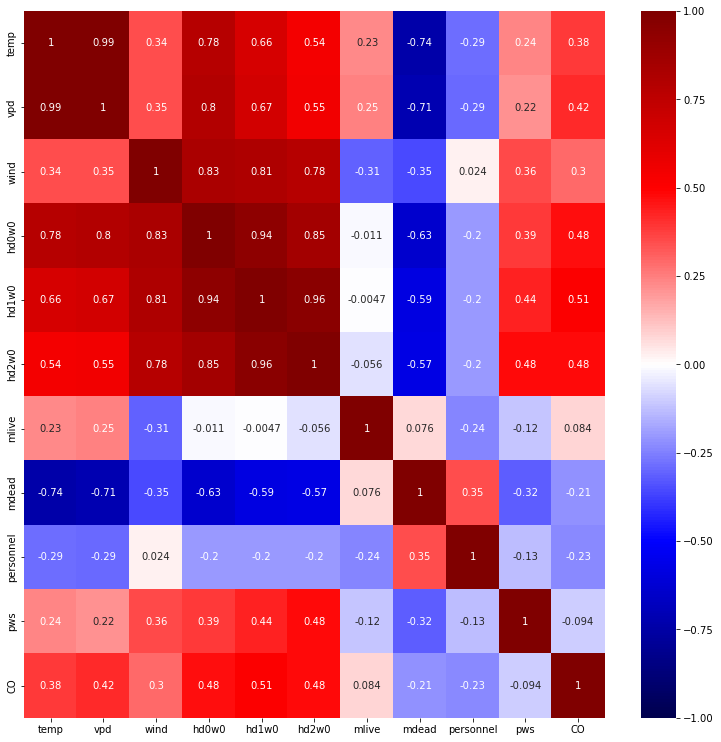

In [36]:
#concatenate all the dataframes
df_all = pd.concat([df_merra.drop(columns=['Unnamed: 0', 'frp', 'area', 'num points']),\
                    df_ncar.drop(columns=['Unnamed: 0']),\
                    df_personnel.drop(columns=['Unnamed: 0']),\
                    df_pws.drop(columns=['Unnamed: 0']),\
                    df_rave['CO']], axis=1)
df_all
corrMatrix = df_all.corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic')
plt.show()

## Make MERRA Time Series Plots

In [ ]:
plot_twoline(df_merra['day'].iloc[0:69], np.stack([df_merra['temp'].iloc[0:69], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Max Temperature (K)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'].iloc[0:69], np.stack([df_merra['vpd'].iloc[0:69], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Max VPD (hPa)', 'CO (kg)'], 1)
plot_twoline(df_merra['day'].iloc[0:69], np.stack([df_merra['wind'].iloc[0:69], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Max Wind (m/s)', 'CO (kg)'], 1)

plot_twoline(df_merra['day'].iloc[0:69], np.stack([df_merra['hd0w0'].iloc[0:69], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Max HD0W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'].iloc[0:69], np.stack([df_merra['hd1w0'].iloc[0:69], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Max HD1W0', 'CO (kg)'], 1)
plot_twoline(df_merra['day'].iloc[0:69], np.stack([df_merra['hd2w0'].iloc[0:69], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Max HD2W0', 'CO (kg)'], 1)

## Make FCCS time Series Plots

In [ ]:
print(df_fccs['fuels'].values)
plot_twoline(df_merra['day'], np.stack([df_fccs['fuels'], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Mode Fuel', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_fccs['slopes'], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Max Slope', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_fccs['aspects'], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Mode Aspect', 'CO (kg)'], 1)

## Make NCAR Fuel Moisture Time Series

In [ ]:
plot_twoline(df_merra['day'], np.stack([df_ncar['mlive'], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Live Fuel Moisure', 'CO (kg)'], 1)
plot_twoline(df_merra['day'], np.stack([df_ncar['mdead'], df_rave['CO']]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisure', 'CO (kg)'], 1)

## Personnel

## Make Corellograms

## Helper Functions

In [4]:
#plots two lines, on one or on the same axis
# IN: datax, x axis vector (time)
# IN: datay, 2*n vector of the data
# IN: linelabels, string vector of the labels of each line, to go in the legend
# IN: axis labels, labels of the axis
# IN: title, string for title of figire
# IN: twoaxis, if 1 plot data on two separate axes, else plot on the same axis
# OUT: a graph
def plot_twoline(datax, datay, title, linelabels, axislabels, twoaxis):
    fig, ax = plt.subplots(figsize=(20,6)) #set up the figure
    
    if twoaxis==1:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.set_ylabel(axislabels[0], fontsize=24, color='red') 
        ax2=ax.twinx()
        ax2.plot(datax, datay[1,:], 'bo-') #plot the second line
        ax2.set_ylabel(axislabels[1], fontsize=24, color='blue')
        
    else:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.plot(datax, datay[1,:], 'bo-') # plot the second line
        ax.set_ylabel(axislabels, fontsize=24) 
    #print(np.arange(1,len(datax.values),6))
    plt.xticks(np.arange(1,len(datax.values),6))    
    plt.legend(linelabels,fontsize=24)
    plt.title(title,fontsize=24)
    plt.grid()
    plt.show()

